In [2]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image, glm
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr, norm

from sklearn.metrics import confusion_matrix

import joblib
import numpy as np
from pathlib import Path

In [3]:
#import data set
df_rest = pd.read_csv("/home/xlajoie/Desktop/Final_restricted.csv")

df_unrest = pd.read_csv("/home/xlajoie/Desktop/Final_unrestricted.csv")


Final_df = pd.merge(df_rest, 
                      df_unrest, 
                      on ='Subject', 
                      how ='inner')
Final_df

Subject  Age_in_Yrs  HasGT ZygositySR ZygosityGT          Family_ID  \
0     100206          27   True    NotTwin                   56037_85858   
1     100610          27   True      NotMZ         DZ        52813_82634   
2     101006          35   True         MZ             51283_52850_81149   
3     101309          29   True    NotTwin                   52385_82248   
4     102008          24   True    NotTwin                   52018_81882   
..       ...         ...    ...        ...        ...                ...   
669   990366          22   True         MZ                   56064_85885   
670   991267          30   True    NotTwin                   51639_81503   
671   992673          33   True    NotTwin                   56143_85963   
672   993675          29   True    NotTwin                   55800_85621   
673   996782          28   True      NotMZ         DZ        51541_81405   

     Mother_ID  Father_ID  TestRetestInterval                  Race  ...  \
0        56037      85858                 NaN                 White  ...   
1        52813      82634                 NaN                 White  ...   
2        51283      81149                 NaN  Black or African Am.  ...   
3        52385      82248                 NaN  Black or African Am.  ...   
4        52018      81882                 NaN                 White  ...   
..         ...        ...                 ...                   ...  ...   
669      56064      85885                 NaN                 White  ...   
670      51639      81503                 NaN                 White  ...   
671      56143      85963                 NaN                 White  ...   
672      55800      85621                 NaN                 White  ...   
673      51541      81405                 NaN                 White  ...   

    Noise_Comp  Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0      108.79        97.19                  1.0   
1          2.0      122.25       110.45                  0.0   
2          6.0      122.25       111.41                  0.0   
3          5.2      122.25       110.45                  0.0   
4          6.0      122.25       110.45                  0.0   
..         ...         ...          ...                  ...   
669        4.4      108.79        97.19                  1.0   
670        2.8      122.25       111.41                  1.0   
671        3.6      122.25       111.41                  1.0   
672        0.4      122.25       110.45                  0.0   
673        6.0      108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 38.6       106.39        104.39            1.80        0.0   
4                 50.1        67.48         65.31            1.80        0.0   
..                 ...          ...           ...             ...        ...   
669               52.6        93.82         92.63            1.80        0.0   
670               46.6        83.23         81.55            1.84        0.0   
671               38.6       101.63         99.26            1.80        0.0   
672               38.6        84.07         84.25            1.80        1.0   
673               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.80  
..          ...  
669        1.80  
670        1.84  
671        1.80  
672        1.76  
673        1.84  

[674 rows x 583 columns]

In [4]:
# Filter left-handers (include >=50 handedness) 
Final_df = Final_df[Final_df["Handedness"] >= 50].reset_index()

# transform M and F with 0 and 1 
Final_df.rename(columns={"Subject": "subject_label"}, inplace=True)
Final_df["Gender"] = Final_df["Gender"].replace({"M": 0, "F": 1})
Final_df

index  subject_label  Age_in_Yrs  HasGT ZygositySR ZygosityGT  \
0        0         100206          27   True    NotTwin              
1        1         100610          27   True      NotMZ         DZ   
2        2         101006          35   True         MZ              
3        4         102008          24   True    NotTwin              
4        7         102513          30   True    NotTwin              
..     ...            ...         ...    ...        ...        ...   
565    669         990366          22   True         MZ              
566    670         991267          30   True    NotTwin              
567    671         992673          33   True    NotTwin              
568    672         993675          29   True    NotTwin              
569    673         996782          28   True      NotMZ         DZ   

             Family_ID  Mother_ID  Father_ID  TestRetestInterval  ...  \
0          56037_85858      56037      85858                 NaN  ...   
1          52813_82634      52813      82634                 NaN  ...   
2    51283_52850_81149      51283      81149                 NaN  ...   
3          52018_81882      52018      81882                 NaN  ...   
4          56077_85897      56077      85897                 NaN  ...   
..                 ...        ...        ...                 ...  ...   
565        56064_85885      56064      85885                 NaN  ...   
566        51639_81503      51639      81503                 NaN  ...   
567        56143_85963      56143      85963                 NaN  ...   
568        55800_85621      55800      85621                 NaN  ...   
569        51541_81405      51541      81405                 NaN  ...   

    Noise_Comp Odor_Unadj  Odor_AgeAdj  PainIntens_RawScore  \
0          6.0     108.79        97.19                  1.0   
1          2.0     122.25       110.45                  0.0   
2          6.0     122.25       111.41                  0.0   
3          6.0     122.25       110.45                  0.0   
4          5.2     108.79        98.04                  2.0   
..         ...        ...          ...                  ...   
565        4.4     108.79        97.19                  1.0   
566        2.8     122.25       111.41                  1.0   
567        3.6     122.25       111.41                  1.0   
568        0.4     122.25       110.45                  0.0   
569        6.0     108.79        97.19                  0.0   

     PainInterf_Tscore  Taste_Unadj  Taste_AgeAdj  Mars_Log_Score  Mars_Errs  \
0                 49.7        72.63         72.03            1.84        0.0   
1                 38.6        84.84         85.31            1.92        1.0   
2                 38.6       123.80        123.31            1.80        0.0   
3                 50.1        67.48         65.31            1.80        0.0   
4                 54.3        84.07         82.37            1.92        0.0   
..                 ...          ...           ...             ...        ...   
565               52.6        93.82         92.63            1.80        0.0   
566               46.6        83.23         81.55            1.84        0.0   
567               38.6       101.63         99.26            1.80        0.0   
568               38.6        84.07         84.25            1.80        1.0   
569               38.6        75.43         73.72            1.84        0.0   

     Mars_Final  
0          1.84  
1          1.88  
2          1.80  
3          1.80  
4          1.92  
..          ...  
565        1.80  
566        1.84  
567        1.80  
568        1.76  
569        1.84  

[570 rows x 584 columns]

In [5]:
print("hommes = ", Final_df["Gender"].value_counts()[0])
print("femmes = ", Final_df["Gender"].value_counts()[1])

hommes =  264
femmes =  306


In [6]:
#save new csv with modifications as "final hcp database"
Final_df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [6]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

# Classification et trouver seed region qui donnent une meilleure classification

In [7]:
def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1) # 8
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [8]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    
    See also nltools summarized_bootstrap function: https://nltools.org/_modules/nltools/stats.html
    """
    mean_scores = np.mean(boot_coefs, axis=0)
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), pval, 0)
    #boot_z_fdr = np.where(pval < fdr(pval, q=0.05), pval, 0)
    
    return mean_scores, z_scores, pval, pval_bonf#, boot_z_fdr

In [9]:
def machine_learning(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    score.append(cross_val_score(model, X_train, y_train, cv=20, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [10]:
def machine_learning_logistic(x, y):
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data
    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x,  # x 
                                                        y,  # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LogisticRegression(random_state = 123)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3))
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc_test = model.score(X_test, y_test)
    acc_train = model.score(X_train, y_train) 

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tp, fn],[fp,tn]], index= ["Femme", "Homme"], columns = ["Femme", "Homme"])
    df_result = df_result.rename_axis("actual class")
    df_result = df_result.rename_axis("predicted class", axis="columns")
    print(df_result)
    
    # print results
    print('accuracy test (r2) =', acc_test)
    print('accuracy train (r2) =', acc_train)
    
    return {
        "len_X_train": len(X_train),
        "len_X_test": len(X_test),
        "score": score,
        "confusion_matrix": df_result,
        "acc_test": acc_test,
        "acc_train": acc_train,
        "model": model,
    }

In [11]:
def run_logistic(df_boot, data, seed):

    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_boot)
    subject_label = df_boot["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_boot["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning_logistic(x_correl, y_sex)

    return x_correl

In [13]:
def run(df_boot, data, seed):
    df_bootstrap = pd.DataFrame()
    for j in range(0, len(df_boot)):
        index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)


    # print(df_bootstrap["Gender"])  # should have the whole list

    x_correl = []
    nb_subjects = len(df_bootstrap)
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    x_correl = []
    for sub in tqdm(subject_label):
        for seed_name in seed:
            x_correl.append(data[sub, seed_name])

    x_correl = np.array(x_correl)
    x_correl = x_correl.reshape(len(df_boot), len(seed)*148)  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds))


    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"])

    coef = machine_learning(x_correl, y_sex)

    return x_correl

In [13]:
def regionsOfInterest(accuracy, pvalue, moyenne, rois, label, x_correl):
    pvalue_val = pvalue.reshape(len(rois), 148).T
    pvalue_uncorrected = pvalue_val < 0.05

    data_pval_uncorrected = pd.DataFrame(pvalue_uncorrected, columns=rois)
    data_pval = pd.DataFrame(pvalue_val, columns=rois)

    pval_corrected = np.multiply(pvalue_val, pvalue_uncorrected)
    
    X_std = x_correl.std()
    weighted_coef = moyenne * X_std
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)

    X_std = x_correl.std()
    weighted_coef = moyenne * X_std                        #REPETITION ICI ^??
    label_name = list(label['name']) * len(rois)
    seed_name = np.repeat(rois, 148)
    
    weighted_tab = pd.DataFrame(weighted_coef, columns=["coefficient"])
    weighted_tab['seed'] = seed_name
    weighted_tab['labels'] = label_name
    
    # print the 10 best seed anf their labels
    print(weighted_tab.sort_values(by=['coefficient'], ascending=False).head(10))
    
    
    # weighted_coef[weighted_coef<0.054609] = 0 # maybe changed the 0.054609 for a variable
        
    
    # printing the accuracy and its interval of confidance
    acc_test = np.asarray(accuracy)
    moy = np.mean(acc_test)
    se = np.std(acc_test)
    lower = moy - (1.96 * se)
    upper = moy + (1.96 * se)
    
    print("The mean accuracy : " + str(moy))
    print("The standard deviation of the accuracy : " + str(se))
    print("The lower boundry of the confidance interval of the accuracy : " + str(lower))
    print("The upper boundry of the confidance interval of the accuracy : " + str(upper))
    
    return weighted_tab

In [14]:
def bestRegion(ROIs):
    
    best = ROIs.sort_values(by=['coefficient'], ascending=False).head(10)
    best_roi = []

    for row in best.iterrows():
        best_roi.append([row[1][1], row[1][2], [], []])

    label_female = []
    label_male = []

    for i in range(0,len(Final_df["Gender"])):
        if Final_df["Gender"][i] == 0:
            label_male.append(Final_df["subject_label"][i])

        elif Final_df["Gender"][i] == 1:
            label_female.append(Final_df["subject_label"][i])
            

    for i in data.keys():
        if label_male.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][2].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

        elif label_female.count(i[0]) > 0:
            for j in range(0, len(best_roi)):
                if (best_roi[j][0] == i[1]):
                    best_roi[j][3].append(data[i[0], best_roi[j][0]][label[label["name"] == best_roi[j][1]].index.values[0]])

    table_best = pd.DataFrame(columns=["Region", "Men", "Women", "P value"])
    for i in range(0, len(best_roi)):
        best_roi[i][2] = np.asarray(best_roi[i][2]) # male
        best_roi[i][3] = np.asarray(best_roi[i][3]) # female
        plt.boxplot([best_roi[i][2], best_roi[i][3]])
        plt.xticks([1,2], ["male", "female"])
        plt.title(best_roi[i][0]+" "+best_roi[i][1])
        plt.show()
        print(stats.ttest_ind(best_roi[i][2], best_roi[i][3]))
        print("male mean : "+ str(np.mean(best_roi[i][2])))
        print("female mean : "+ str(np.mean(best_roi[i][3])))
        table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],
                                        'Men' : np.mean(best_roi[i][2]), 
                                        'Women' : np.mean(best_roi[i][3]), 
                                        'P value' : stats.ttest_ind(best_roi[i][2], best_roi[i][3])[1]}, ignore_index=True)
        
    print(table_best)

## Single run with all seed

In [15]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [16]:
bootstrap_coef = []
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_seed-{seed_name}_mean-4_voxelcorrelations.nii.gz"
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

data = {}

for seed in SEEDS:
    for sub in tqdm(df_boot["subject_label"]):
        img_path = img_tpl.format(seed_name=seed, participant_id=sub)
        data[(sub, seed)] = img4d2vector(img_path, masker)
        

/home/xlajoie/Desktop/sex_diff/venv/polyssifier/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
100%|█████████████████████████████████████████| 570/570 [02:36<00:00,  3.64it/s]


In [17]:
run_1 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 580561.75it/s]


train: 456 test: 114
[array([0.91304348, 0.95652174, 0.73913043, 0.82608696, 0.86956522,
       1.        , 1.        , 0.95652174, 0.86956522, 0.7826087 ,
       0.91304348, 0.95652174, 1.        , 0.86956522, 0.91304348,
       0.82608696, 0.90909091, 0.81818182, 1.        , 0.81818182])]
predicted class  Femme  Homme
actual class                 
Femme               55      6
Homme                2     51
accuracy test (r2) = 0.9298245614035088
accuracy train (r2) = 1.0


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [18]:
run_cv10 = run(df, data, ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"])

100%|█████████████████████████████████████| 570/570 [00:00<00:00, 476625.45it/s]


train: 456 test: 114
[array([0.95652174, 1.        , 0.95652174, 0.91304348, 0.95652174,
       0.91304348, 0.91304348, 0.86956522, 0.73913043, 0.91304348,
       0.91304348, 0.91304348, 0.86956522, 0.91304348, 0.95652174,
       0.91304348, 1.        , 1.        , 0.90909091, 0.95454545])]
predicted class  Femme  Homme
actual class                 
Femme               56      5
Homme                2     51
accuracy test (r2) = 0.9385964912280702
accuracy train (r2) = 1.0


## Bootstrap result all seed, single seed, all left seed and all right seed

In [167]:
study_dir = Path('/data/brambati/dataset/HCP/derivatives/training_sex_diff/')
results_path_all_seed = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-all_mean_LinearSVC.pkl"
results_path_aMTG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_L_mean_LinearSVC.pkl"
results_path_aMTG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-aMTG_R_mean_LinearSVC.pkl"
results_path_opIFG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_L_mean_LinearSVC.pkl"
results_path_opIFG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-opIFG_R_mean_LinearSVC.pkl"
results_path_pITG_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_L_mean_LinearSVC.pkl"
results_path_pITG_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-pITG_R_mean_LinearSVC.pkl"
results_path_planumtemp_L = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_L_mean_LinearSVC.pkl"
results_path_planumtemp_R = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-planumtemp_R_mean_LinearSVC.pkl"
results_path_all_left = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-left_mean_LinearSVC.pkl"
results_path_all_right = study_dir / "results" / "LinearSVC" / "models_iteration-10000_seeds-right_mean_LinearSVC.pkl"



results = joblib.load(results_path_all_seed)

coefs = []
for result in results:
    coefs.append(result["model"].coef_[0])

coefs = np.array(coefs)

data_results = pd.DataFrame.from_dict(results)
moyenne, scoresZ, pvalue, pvalue_bonf = bootstrap_scores(coefs)
moyenne.shape

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(1184,)

In [11]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
label = atlas_dest["labels"].drop([0,42,117]) # correction for the destrieux atlas labels
label = label.reset_index()

# Dataframe for violinplot

In [2]:
df = pd.DataFrame.from_dict(data, orient="index", columns=label["name"]).reset_index()
df["participant_id"] = df["index"].apply(lambda x: x[0])
df["seed"] = df["index"].apply(lambda x: x[1])
df["Gender"] = list(Final_df["Gender"]) * 8
df["Gender"] = df["Gender"].replace({0:"men", 1:"women"})
df

NameError: name 'data' is not defined

In [155]:
df_connectivity = df.melt(id_vars=["participant_id", "seed", "Gender"], value_vars=label["name"])
df_connectivity["pair"] = df_connectivity["seed"] + " with " + df_connectivity["name"]
df_connectivity

participant_id     seed Gender                     name     value  \
0               100206  opIFG_L    men   L G_and_S_frontomargin -0.004726   
1               100610  opIFG_L    men   L G_and_S_frontomargin  0.019454   
2               101006  opIFG_L  women   L G_and_S_frontomargin -0.008363   
3               102008  opIFG_L    men   L G_and_S_frontomargin  0.081125   
4               102513  opIFG_L    men   L G_and_S_frontomargin  0.015992   
...                ...      ...    ...                      ...       ...   
674875          990366   pITG_R    men  R S_temporal_transverse  0.128093   
674876          991267   pITG_R    men  R S_temporal_transverse  0.102424   
674877          992673   pITG_R  women  R S_temporal_transverse  0.131250   
674878          993675   pITG_R  women  R S_temporal_transverse  0.059007   
674879          996782   pITG_R  women  R S_temporal_transverse  0.152758   

                                       pair  
0       opIFG_L with L G_and_S_frontomargin  
1       opIFG_L with L G_and_S_frontomargin  
2       opIFG_L with L G_and_S_frontomargin  
3       opIFG_L with L G_and_S_frontomargin  
4       opIFG_L with L G_and_S_frontomargin  
...                                     ...  
674875  pITG_R with R S_temporal_transverse  
674876  pITG_R with R S_temporal_transverse  
674877  pITG_R with R S_temporal_transverse  
674878  pITG_R with R S_temporal_transverse  
674879  pITG_R with R S_temporal_transverse  

[674880 rows x 6 columns]

[Text(0, 0, 'aMTG_L +\n Destrieux 43'), Text(1, 0, 'Top 2')]

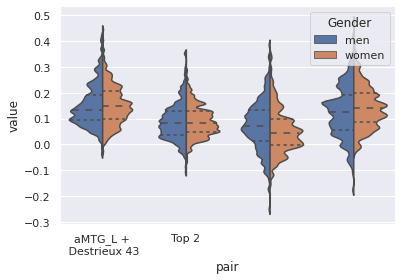

In [165]:
# list to make sure top 10 regions are in order 

top10 = ["aMTG_L with L S_front_sup", "aMTG_L with R G_pariet_inf-Angular", "pITG_L with R G_front_inf-Orbital", "aMTG_L with L G_and_S_transv_frontopol", "planumtemp_R with L S_interm_prim-Jensen", "

df_temp = df_connectivity.loc[
    #(df_connectivity["seed"] == "opIFG_L") &
    (df_connectivity["pair"].isin(["aMTG_L with L S_front_sup", "aMTG_L with R G_pariet_inf-Angular", "pITG_L with R G_front_inf-Orbital", "aMTG_L with L G_and_S_transv_frontopol"]))
]  # entrer manuellement les top 10 meilleurs seed labels pairs 

v_plot = sns.violinplot(x="pair", y="value", hue="Gender", data=df_temp, split=True, bw=.10,inner= "quartile")
v_plot.set_xticks([0,1])
v_plot.set_xticklabels(["aMTG_L +\n Destrieux 43", "Top 2"])

## Best regions for all seeds

      coefficient          seed                      labels
349      0.066002        aMTG_L               L S_front_sup
394      0.065635        aMTG_L      R G_pariet_inf-Angular
530      0.060821        pITG_L       R G_front_inf-Orbital
300      0.059656        aMTG_L  L G_and_S_transv_frontopol
794      0.058644  planumtemp_R      L S_interm_prim-Jensen
1056     0.058182        pITG_R     L G_oc-temp_lat-fusifor
453      0.056814        pITG_L     L G_cingul-Post-ventral
41       0.055782       opIFG_L            L Pole_occipital
783      0.055005  planumtemp_R               L S_calcarine
941      0.050793        aMTG_R               L S_front_sup
The mean accuracy : 0.916316814159292
The standard deviation of the accuracy : 0.027862591976324208
The lower boundry of the confidance interval of the accuracy : 0.8617061338856966
The upper boundry of the confidance interval of the accuracy : 0.9709274944328874


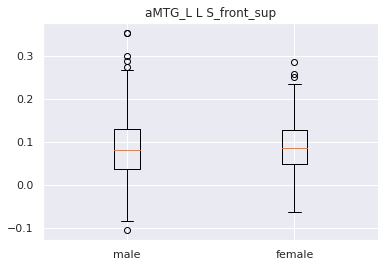

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


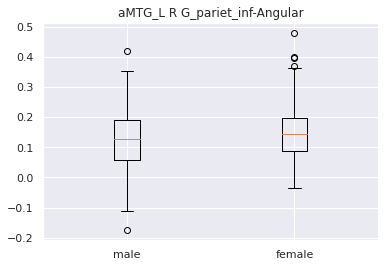

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


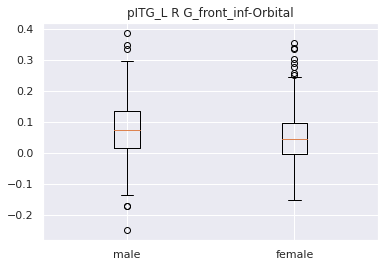

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


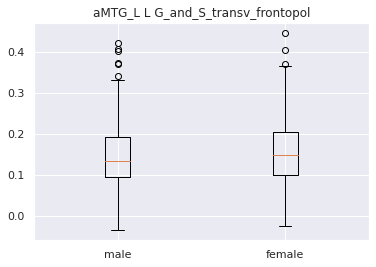

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


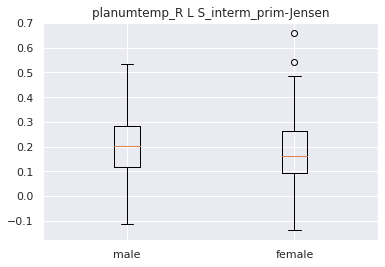

Ttest_indResult(statistic=2.6529671893777285, pvalue=0.008201963044888232)
male mean : 0.20600034
female mean : 0.17834951


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


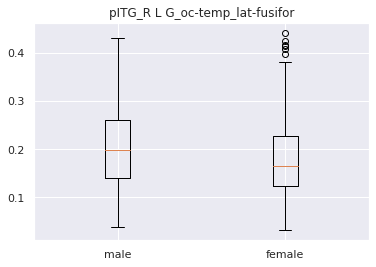

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


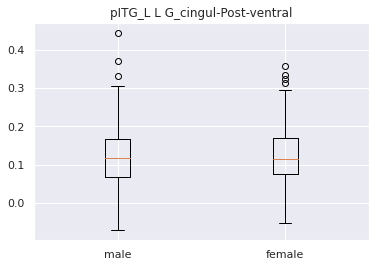

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


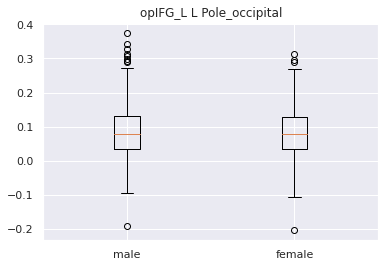

Ttest_indResult(statistic=1.0227015449858845, pvalue=0.30688434881270166)
male mean : 0.08923399
female mean : 0.08254886


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


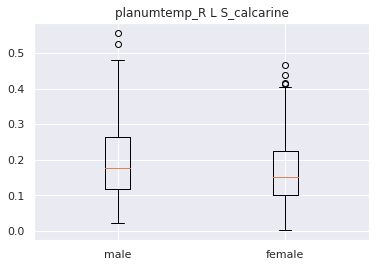

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


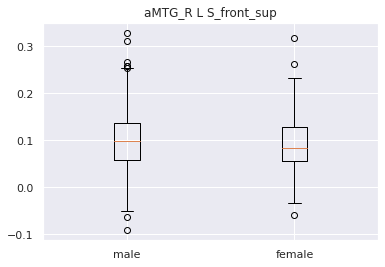

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379
                                  Region       Men     Women   P value
0                 aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1        aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2         pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
3    aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
4  planumtemp_R - L S_interm_prim-Jensen     0.206   0.17835  0.008202
5       pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
6       pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
7             opIFG_L - L Pole_occipital  0.089234  0.082549  0.306884
8           planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
9                 aMTG_R - L S_front_sup  0.099769  0.092938  0.189909


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [169]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_L

     coefficient    seed                       labels
53      0.176693  aMTG_L                L S_front_sup
98      0.150133  aMTG_L       R G_pariet_inf-Angular
4       0.145356  aMTG_L   L G_and_S_transv_frontopol
78      0.119832  aMTG_L   R G_and_S_transv_frontopol
64      0.118726  aMTG_L        L S_parieto_occipital
104     0.112307  aMTG_L                   R G_rectus
55      0.108740  aMTG_L  L S_intrapariet_and_P_trans
103     0.107928  aMTG_L                R G_precuneus
135     0.105442  aMTG_L          R S_orbital_lateral
87      0.105395  aMTG_L       R G_front_inf-Triangul
The mean accuracy : 0.7934628318584072
The standard deviation of the accuracy : 0.0388570983771416
The lower boundry of the confidance interval of the accuracy : 0.7173029190392096
The upper boundry of the confidance interval of the accuracy : 0.8696227446776047


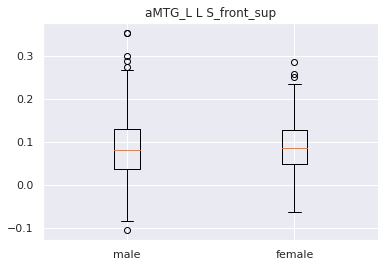

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


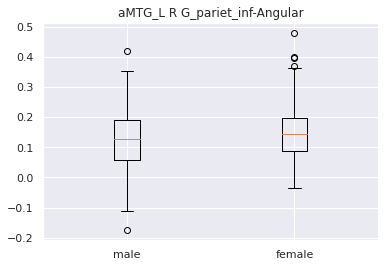

Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


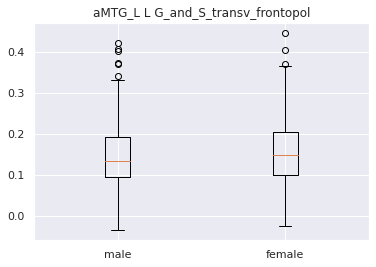

/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


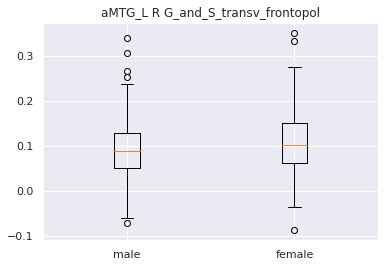

Ttest_indResult(statistic=-2.571148551614975, pvalue=0.010389553654298302)
male mean : 0.09560566
female mean : 0.10965275


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


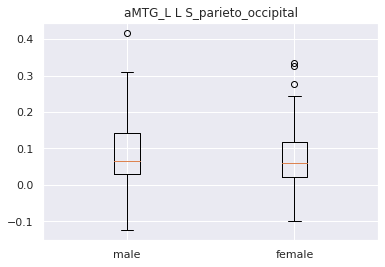

Ttest_indResult(statistic=2.436477854231027, pvalue=0.015137232912866961)
male mean : 0.08481123
female mean : 0.06949203


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


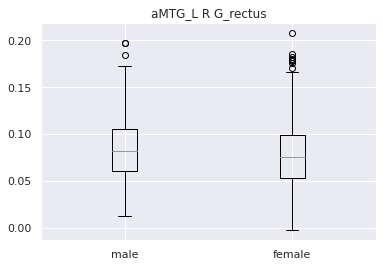

/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=1.7718693697468806, pvalue=0.07695230445602227)
male mean : 0.08437557
female mean : 0.0790933


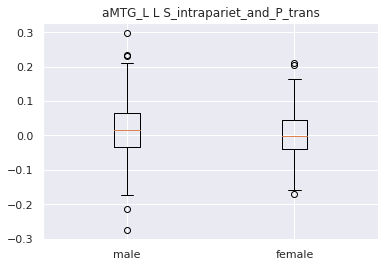

Ttest_indResult(statistic=1.5534617198947105, pvalue=0.1208698513554686)
male mean : 0.014690557
female mean : 0.005323266


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


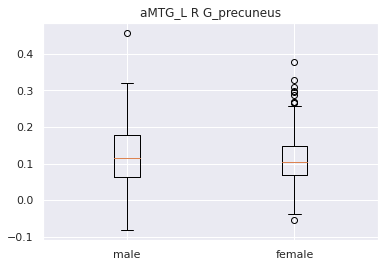

Ttest_indResult(statistic=1.328116736773145, pvalue=0.1846729623828725)
male mean : 0.11954241
female mean : 0.1113971


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


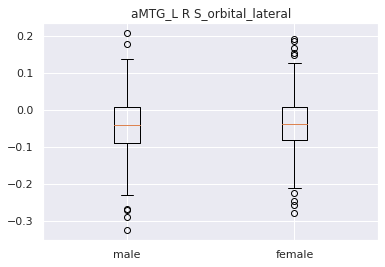

Ttest_indResult(statistic=-1.292465867685566, pvalue=0.1967213906190116)
male mean : -0.042981237
female mean : -0.034570992


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


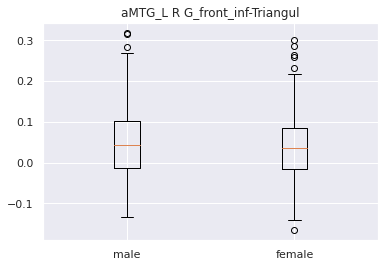

Ttest_indResult(statistic=1.1987429233926812, pvalue=0.23112780424526547)
male mean : 0.04718627
female mean : 0.03892026
                                 Region       Men     Women   P value
0                aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1       aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
2   aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
3   aMTG_L - R G_and_S_transv_frontopol  0.095606  0.109653   0.01039
4        aMTG_L - L S_parieto_occipital  0.084811  0.069492  0.015137
5                   aMTG_L - R G_rectus  0.084376  0.079093  0.076952
6  aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323   0.12087
7                aMTG_L - R G_precuneus  0.119542  0.111397  0.184673
8          aMTG_L - R S_orbital_lateral -0.042981 -0.034571  0.196721
9       aMTG_L - R G_front_inf-Triangul  0.047186   0.03892  0.231128


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [35]:
rois = ["aMTG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for aMTG_R

     coefficient    seed                      labels
53      0.145697  aMTG_R               L S_front_sup
4       0.135337  aMTG_R  L G_and_S_transv_frontopol
78      0.130804  aMTG_R  R G_and_S_transv_frontopol
90      0.127246  aMTG_R   R G_Ins_lg_and_S_cent_ins
135     0.125702  aMTG_R         R S_orbital_lateral
104     0.115081  aMTG_R                  R G_rectus
66      0.113464  aMTG_R             L S_postcentral
22      0.112400  aMTG_R     L G_oc-temp_med-Parahip
98      0.109070  aMTG_R      R G_pariet_inf-Angular
99      0.107120  aMTG_R     R G_pariet_inf-Supramar
The mean accuracy : 0.7966398230088495
The standard deviation of the accuracy : 0.03879528120382583
The lower boundry of the confidance interval of the accuracy : 0.7206010718493508
The upper boundry of the confidance interval of the accuracy : 0.8726785741683482


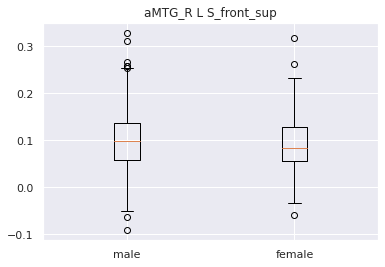

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


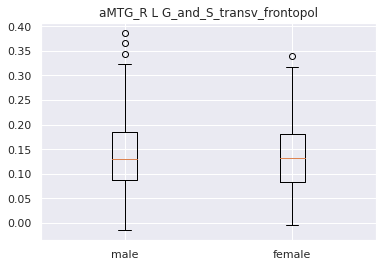

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


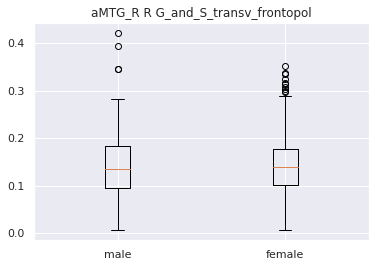

Ttest_indResult(statistic=-0.5021313679136576, pvalue=0.615769711298541)
male mean : 0.14287779
female mean : 0.14569084


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


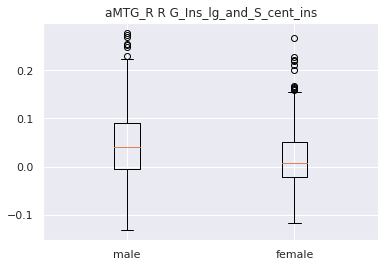

Ttest_indResult(statistic=5.221764124207272, pvalue=2.490516221055385e-07)
male mean : 0.048215896
female mean : 0.018546933


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


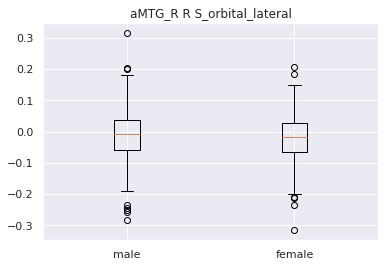

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


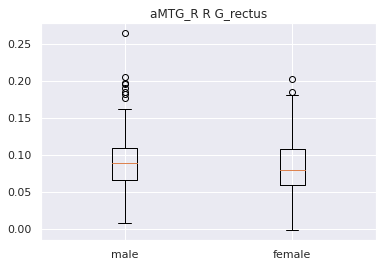

Ttest_indResult(statistic=1.9274704812509191, pvalue=0.05441935708501459)
male mean : 0.090095855
female mean : 0.08406715


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


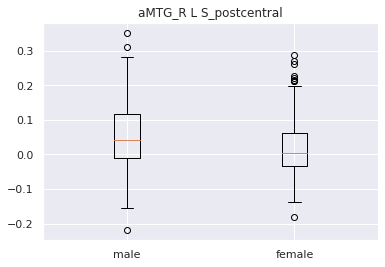

Ttest_indResult(statistic=4.322259791116856, pvalue=1.823637503842923e-05)
male mean : 0.04981075
female mean : 0.01834556


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


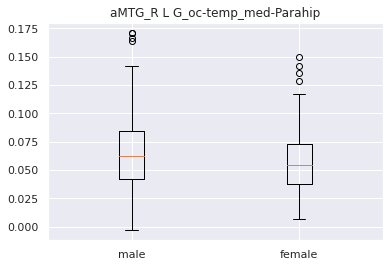

Ttest_indResult(statistic=3.283470689404765, pvalue=0.0010884267262889374)
male mean : 0.06574333
female mean : 0.057849534


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


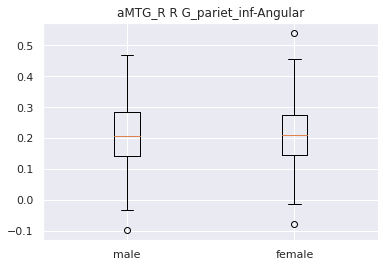

Ttest_indResult(statistic=0.3243155515075406, pvalue=0.7458185428544883)
male mean : 0.21665388
female mean : 0.21397533


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


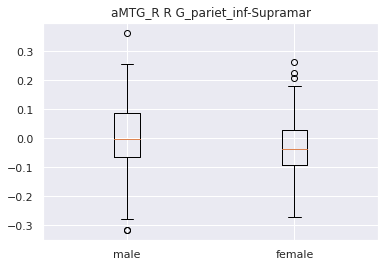

Ttest_indResult(statistic=3.8712274991600824, pvalue=0.00012086637161246554)
male mean : 0.004401155
female mean : -0.028612275
                                Region       Men     Women   P value
0               aMTG_R - L S_front_sup  0.099769  0.092938  0.189909
1  aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146   0.53795
2  aMTG_R - R G_and_S_transv_frontopol  0.142878  0.145691   0.61577
3   aMTG_R - R G_Ins_lg_and_S_cent_ins  0.048216  0.018547       0.0
4         aMTG_R - R S_orbital_lateral -0.010003 -0.016049  0.372737
5                  aMTG_R - R G_rectus  0.090096  0.084067  0.054419
6             aMTG_R - L S_postcentral  0.049811  0.018346  0.000018
7     aMTG_R - L G_oc-temp_med-Parahip  0.065743   0.05785  0.001088
8      aMTG_R - R G_pariet_inf-Angular  0.216654  0.213975  0.745819
9     aMTG_R - R G_pariet_inf-Supramar  0.004401 -0.028612  0.000121


/tmp/ipykernel_4101347/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [37]:
rois = ["aMTG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_L

     coefficient     seed                       labels
20      0.176052  opIFG_L      L G_oc-temp_lat-fusifor
47      0.126844  opIFG_L      L S_circular_insula_inf
72      0.121084  opIFG_L             L S_temporal_sup
40      0.120586  opIFG_L               L Lat_Fis-post
60      0.118387  opIFG_L  L S_oc-temp_med_and_Lingual
89      0.113857  opIFG_L                R G_front_sup
91      0.102999  opIFG_L            R G_insular_short
15      0.102761  opIFG_L                L G_front_sup
144     0.097364  opIFG_L              R S_subparietal
125     0.094412  opIFG_L                R S_front_inf
The mean accuracy : 0.8263690265486726
The standard deviation of the accuracy : 0.03637730928834068
The lower boundry of the confidance interval of the accuracy : 0.7550695003435248
The upper boundry of the confidance interval of the accuracy : 0.8976685527538204


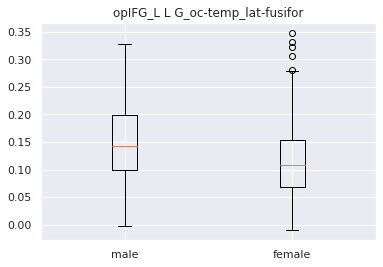

Ttest_indResult(statistic=5.8491198530470045, pvalue=8.347799493217066e-09)
male mean : 0.14884304
female mean : 0.116547726


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


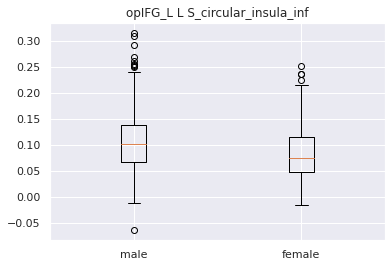

Ttest_indResult(statistic=5.852005785497293, pvalue=8.212302424670442e-09)
male mean : 0.10906584
female mean : 0.08297677


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


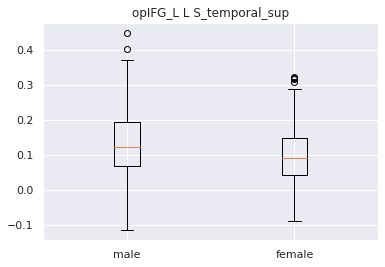

Ttest_indResult(statistic=5.019154197380697, pvalue=6.954734958214046e-07)
male mean : 0.13418752
female mean : 0.09735045


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


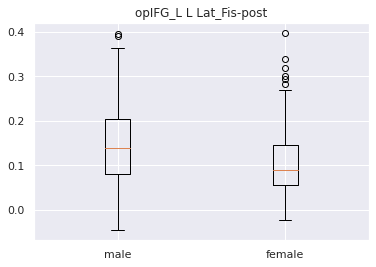

Ttest_indResult(statistic=6.364933392751482, pvalue=4.029331087681434e-10)
male mean : 0.14507884
female mean : 0.104537904


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


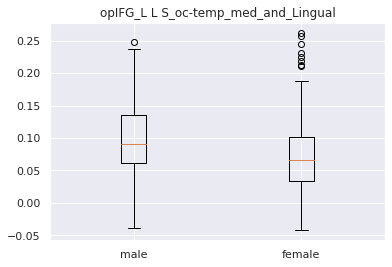

/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=5.76164855973489, pvalue=1.3664471966255358e-08)
male mean : 0.099059284
female mean : 0.073048


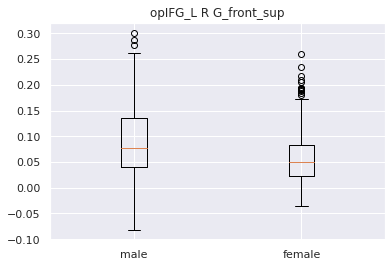

Ttest_indResult(statistic=5.707568607044662, pvalue=1.847405565322988e-08)
male mean : 0.09004138
female mean : 0.060023844


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


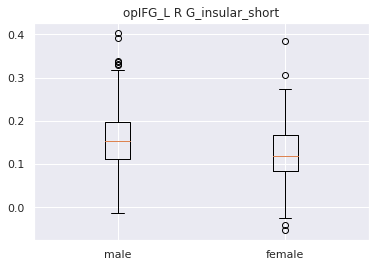

Ttest_indResult(statistic=6.392458725124564, pvalue=3.407311952931533e-10)
male mean : 0.16011919
female mean : 0.12473471


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


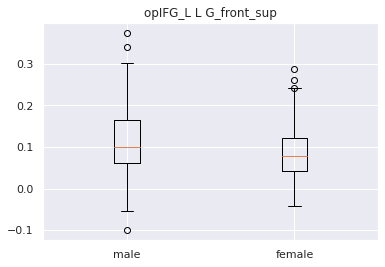

Ttest_indResult(statistic=4.949296258608313, pvalue=9.83059436081603e-07)
male mean : 0.114358306
female mean : 0.08558884


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


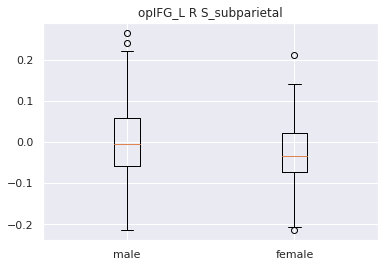

Ttest_indResult(statistic=4.51212448116301, pvalue=7.803845562268264e-06)
male mean : 0.0030093843
female mean : -0.026990896


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


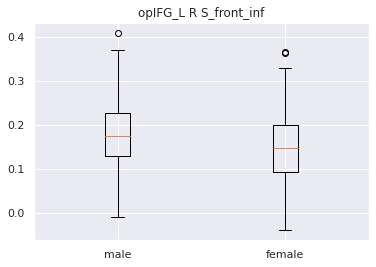

Ttest_indResult(statistic=5.638897608241495, pvalue=2.7000682578262666e-08)
male mean : 0.18022624
female mean : 0.14647487
                                  Region       Men     Women   P value
0      opIFG_L - L G_oc-temp_lat-fusifor  0.148843  0.116548       0.0
1      opIFG_L - L S_circular_insula_inf  0.109066  0.082977       0.0
2             opIFG_L - L S_temporal_sup  0.134188   0.09735  0.000001
3               opIFG_L - L Lat_Fis-post  0.145079  0.104538       0.0
4  opIFG_L - L S_oc-temp_med_and_Lingual  0.099059  0.073048       0.0
5                opIFG_L - R G_front_sup  0.090041  0.060024       0.0
6            opIFG_L - R G_insular_short  0.160119  0.124735       0.0
7                opIFG_L - L G_front_sup  0.114358  0.085589  0.000001
8              opIFG_L - R S_subparietal  0.003009 -0.026991  0.000008
9                opIFG_L - R S_front_inf  0.180226  0.146475       0.0


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [51]:
rois = ["opIFG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for opIFG_R

     coefficient     seed                       labels
121     0.163440  opIFG_R      R S_circular_insula_inf
20      0.158505  opIFG_R      L G_oc-temp_lat-fusifor
47      0.145981  opIFG_R      L S_circular_insula_inf
125     0.141527  opIFG_R                R S_front_inf
90      0.140875  opIFG_R    R G_Ins_lg_and_S_cent_ins
60      0.140475  opIFG_R  L S_oc-temp_med_and_Lingual
41      0.118200  opIFG_R             L Pole_occipital
91      0.116839  opIFG_R            R G_insular_short
80      0.114148  opIFG_R     R G_and_S_cingul-Mid-Ant
144     0.112009  opIFG_R              R S_subparietal
The mean accuracy : 0.8182610619469025
The standard deviation of the accuracy : 0.03808114602208953
The lower boundry of the confidance interval of the accuracy : 0.7436220157436071
The upper boundry of the confidance interval of the accuracy : 0.8929001081501979


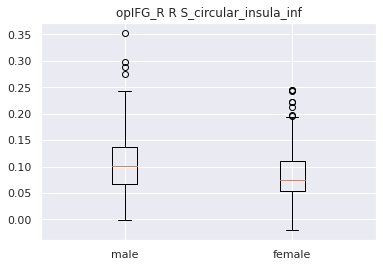

Ttest_indResult(statistic=5.226547983016146, pvalue=2.429845275450505e-07)
male mean : 0.10671159
female mean : 0.08417532


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


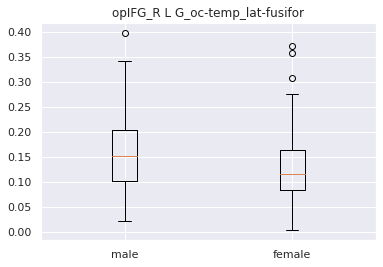

Ttest_indResult(statistic=5.732376818088248, pvalue=1.609202883985806e-08)
male mean : 0.1562101
female mean : 0.12528288


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


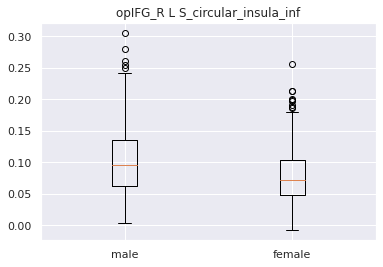

Ttest_indResult(statistic=5.209214471386057, pvalue=2.656732376950302e-07)
male mean : 0.10079068
female mean : 0.079217285


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


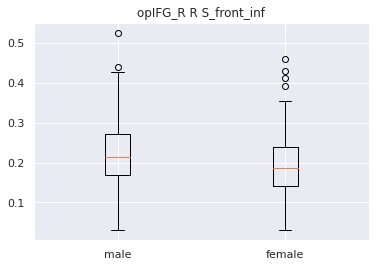

Ttest_indResult(statistic=5.115644829965803, pvalue=4.282989746232668e-07)
male mean : 0.2219755
female mean : 0.1895739


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


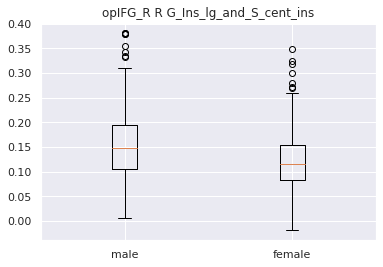

Ttest_indResult(statistic=5.739625655933474, pvalue=1.545440086293778e-08)
male mean : 0.15487437
female mean : 0.12380144


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


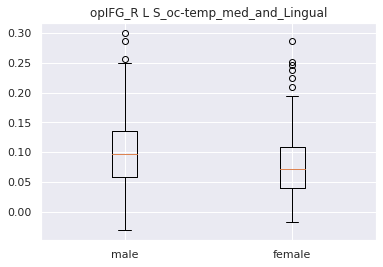

Ttest_indResult(statistic=4.827321505738625, pvalue=1.7812051723580022e-06)
male mean : 0.10082634
female mean : 0.07872187


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


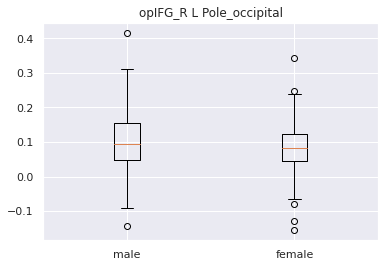

Ttest_indResult(statistic=2.8938857514023053, pvalue=0.0039511454822068635)
male mean : 0.104489796
female mean : 0.086915694


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


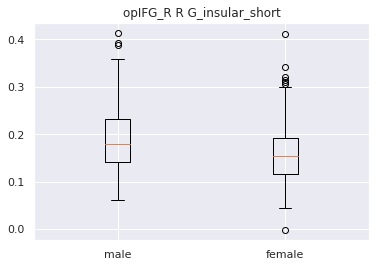

Ttest_indResult(statistic=6.055881429843483, pvalue=2.5410117264590037e-09)
male mean : 0.18950616
female mean : 0.15782672


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


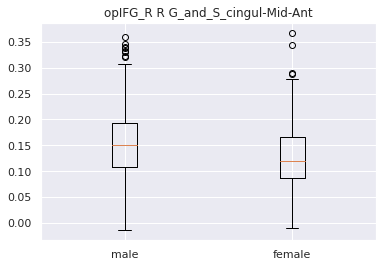

/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=5.1899086135822605, pvalue=2.933595035412797e-07)
male mean : 0.15612759
female mean : 0.12868549


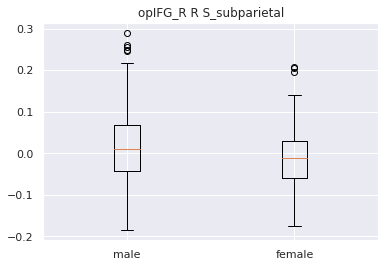

Ttest_indResult(statistic=4.565861009572576, pvalue=6.1028631539739194e-06)
male mean : 0.016530583
female mean : -0.012515795
                                  Region       Men     Women   P value
0      opIFG_R - R S_circular_insula_inf  0.106712  0.084175       0.0
1      opIFG_R - L G_oc-temp_lat-fusifor   0.15621  0.125283       0.0
2      opIFG_R - L S_circular_insula_inf  0.100791  0.079217       0.0
3                opIFG_R - R S_front_inf  0.221976  0.189574       0.0
4    opIFG_R - R G_Ins_lg_and_S_cent_ins  0.154874  0.123801       0.0
5  opIFG_R - L S_oc-temp_med_and_Lingual  0.100826  0.078722  0.000002
6             opIFG_R - L Pole_occipital   0.10449  0.086916  0.003951
7            opIFG_R - R G_insular_short  0.189506  0.157827       0.0
8     opIFG_R - R G_and_S_cingul-Mid-Ant  0.156128  0.128685       0.0
9              opIFG_R - R S_subparietal  0.016531 -0.012516  0.000006


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [53]:
rois = ["opIFG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_L

     coefficient    seed                       labels
9       0.194030  pITG_L      L G_cingul-Post-ventral
26      0.169902  pITG_L             L G_parietal_sup
20      0.165753  pITG_L      L G_oc-temp_lat-fusifor
86      0.151010  pITG_L        R G_front_inf-Orbital
55      0.143049  pITG_L  L S_intrapariet_and_P_trans
125     0.130650  pITG_L                R S_front_inf
83      0.128007  pITG_L      R G_cingul-Post-ventral
4       0.126258  pITG_L   L G_and_S_transv_frontopol
115     0.121504  pITG_L             R Pole_occipital
66      0.119557  pITG_L              L S_postcentral
The mean accuracy : 0.8041539823008849
The standard deviation of the accuracy : 0.038765247723237035
The lower boundry of the confidance interval of the accuracy : 0.7281740967633403
The upper boundry of the confidance interval of the accuracy : 0.8801338678384294


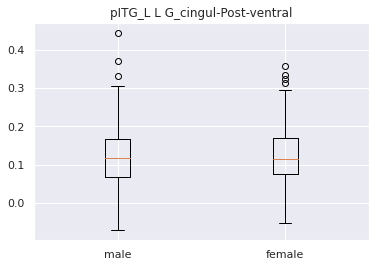

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


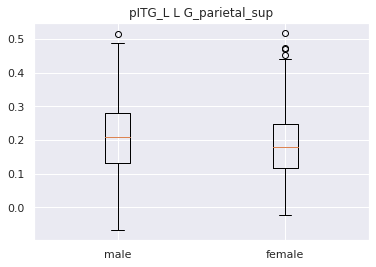

Ttest_indResult(statistic=2.776333935754648, pvalue=0.005678904619509242)
male mean : 0.21009725
female mean : 0.18630977


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


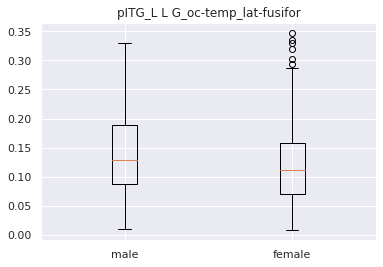

/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=3.156077082866602, pvalue=0.0016837809817830673)
male mean : 0.13884458
female mean : 0.1213442


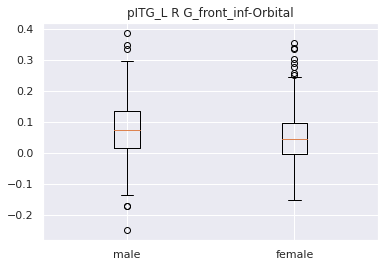

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


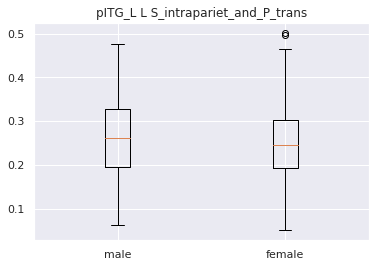

Ttest_indResult(statistic=2.210150284070341, pvalue=0.027492662382419545)
male mean : 0.2640814
female mean : 0.24852245


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


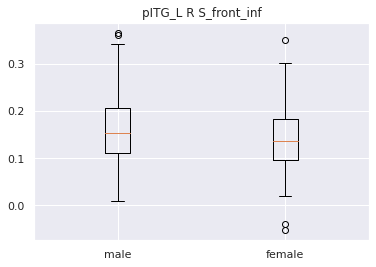

Ttest_indResult(statistic=3.4759879317703635, pvalue=0.0005478613658807853)
male mean : 0.16004132
female mean : 0.14065996


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


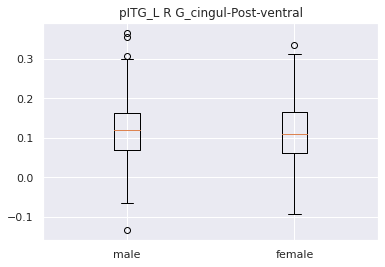

Ttest_indResult(statistic=0.09601695482038536, pvalue=0.9235409730092512)
male mean : 0.11851825
female mean : 0.11792118


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


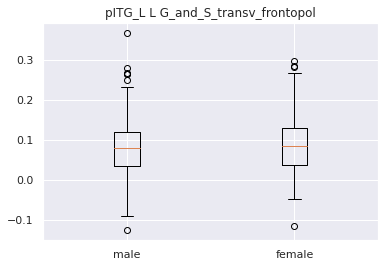

Ttest_indResult(statistic=-0.7998487955908873, pvalue=0.42413278500505813)
male mean : 0.083293684
female mean : 0.08794802


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


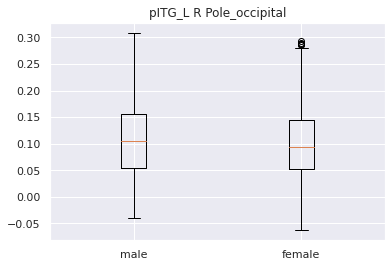

Ttest_indResult(statistic=1.39165171012916, pvalue=0.1645726291539082)
male mean : 0.11096361
female mean : 0.10281154


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


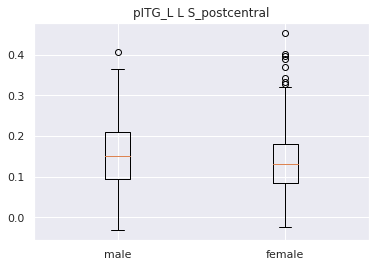

Ttest_indResult(statistic=2.5890681056057545, pvalue=0.009870223882467003)
male mean : 0.15819883
female mean : 0.14057475
                                 Region       Men     Women   P value
0      pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
1             pITG_L - L G_parietal_sup  0.210097   0.18631  0.005679
2      pITG_L - L G_oc-temp_lat-fusifor  0.138845  0.121344  0.001684
3        pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4  pITG_L - L S_intrapariet_and_P_trans  0.264081  0.248522  0.027493
5                pITG_L - R S_front_inf  0.160041   0.14066  0.000548
6      pITG_L - R G_cingul-Post-ventral  0.118518  0.117921  0.923541
7   pITG_L - L G_and_S_transv_frontopol  0.083294  0.087948  0.424133
8             pITG_L - R Pole_occipital  0.110964  0.102812  0.164573
9              pITG_L - L S_postcentral  0.158199  0.140575   0.00987


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [56]:
rois = ["pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for pITG_R

     coefficient    seed                     labels
20      0.210618  pITG_R    L G_oc-temp_lat-fusifor
125     0.168577  pITG_R              R S_front_inf
72      0.151920  pITG_R           L S_temporal_sup
83      0.143204  pITG_R    R G_cingul-Post-ventral
84      0.122677  pITG_R                 R G_cuneus
90      0.110952  pITG_R  R G_Ins_lg_and_S_cent_ins
66      0.110374  pITG_R            L S_postcentral
47      0.105690  pITG_R    L S_circular_insula_inf
80      0.101654  pITG_R   R G_and_S_cingul-Mid-Ant
144     0.097964  pITG_R            R S_subparietal
The mean accuracy : 0.803787610619469
The standard deviation of the accuracy : 0.03911586112149067
The lower boundry of the confidance interval of the accuracy : 0.7271205228213473
The upper boundry of the confidance interval of the accuracy : 0.8804546984175907


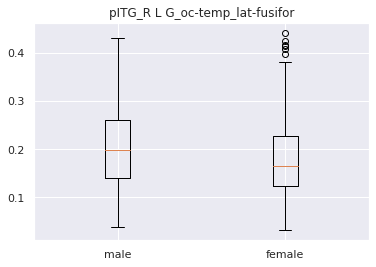

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


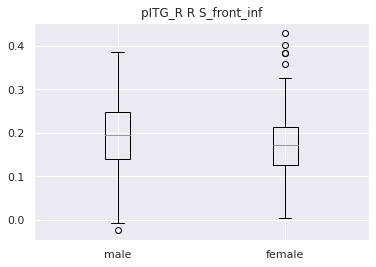

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


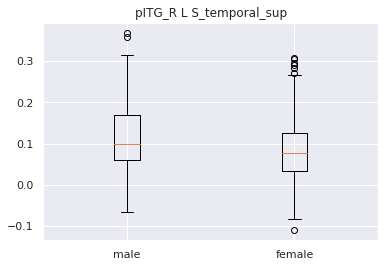

Ttest_indResult(statistic=5.074089384931722, pvalue=5.282429620160145e-07)
male mean : 0.11588306
female mean : 0.082715824


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


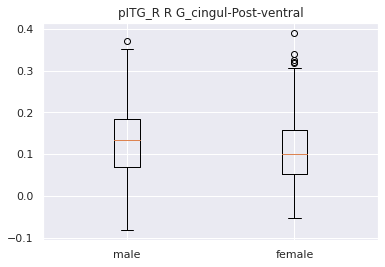

Ttest_indResult(statistic=2.7984808337835725, pvalue=0.0053086933505674845)
male mean : 0.1303599
female mean : 0.110936716


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


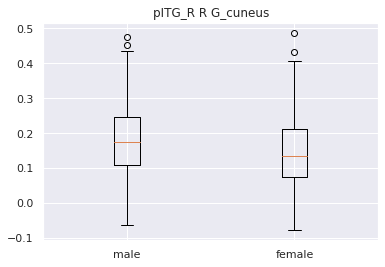

Ttest_indResult(statistic=3.905515094980048, pvalue=0.00010533315735719154)
male mean : 0.18062297
female mean : 0.14835264


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


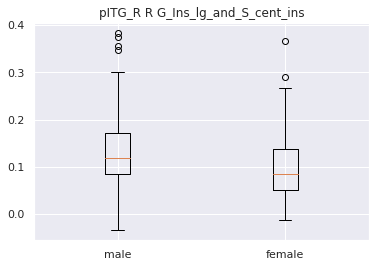

Ttest_indResult(statistic=5.819424388125569, pvalue=9.874878092431944e-09)
male mean : 0.12975526
female mean : 0.09711951


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


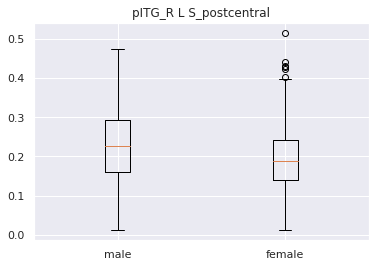

Ttest_indResult(statistic=4.500613935739143, pvalue=8.223189970303467e-06)
male mean : 0.22811967
female mean : 0.19511805


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


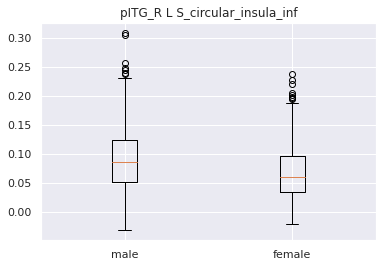

Ttest_indResult(statistic=5.3129048307989155, pvalue=1.5516951922225732e-07)
male mean : 0.093431704
female mean : 0.07025469


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


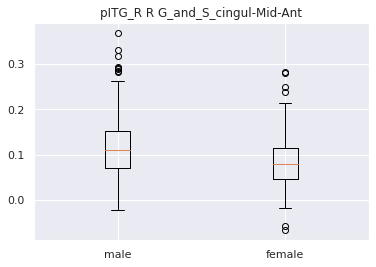

Ttest_indResult(statistic=6.329006454311802, pvalue=5.010627605450198e-10)
male mean : 0.116088144
female mean : 0.08355036


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


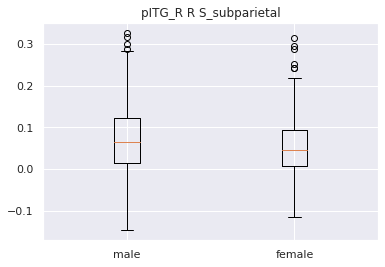

Ttest_indResult(statistic=3.0028167290028893, pvalue=0.002792640236251615)
male mean : 0.07293796
female mean : 0.053484038
                               Region       Men     Women   P value
0    pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
1              pITG_R - R S_front_inf  0.195457  0.174584  0.000361
2           pITG_R - L S_temporal_sup  0.115883  0.082716  0.000001
3    pITG_R - R G_cingul-Post-ventral   0.13036  0.110937  0.005309
4                 pITG_R - R G_cuneus  0.180623  0.148353  0.000105
5  pITG_R - R G_Ins_lg_and_S_cent_ins  0.129755   0.09712       0.0
6            pITG_R - L S_postcentral   0.22812  0.195118  0.000008
7    pITG_R - L S_circular_insula_inf  0.093432  0.070255       0.0
8   pITG_R - R G_and_S_cingul-Mid-Ant  0.116088   0.08355       0.0
9            pITG_R - R S_subparietal  0.072938  0.053484  0.002793


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [58]:
rois = ["pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_L

     coefficient          seed                       labels
20      0.188365  planumtemp_L      L G_oc-temp_lat-fusifor
60      0.172838  planumtemp_L  L S_oc-temp_med_and_Lingual
94      0.152369  planumtemp_L      R G_oc-temp_lat-fusifor
108     0.145260  planumtemp_L      R G_temp_sup-Plan_polar
15      0.123366  planumtemp_L                L G_front_sup
43      0.118439  planumtemp_L                L S_calcarine
66      0.117543  planumtemp_L              L S_postcentral
80      0.103277  planumtemp_L     R G_and_S_cingul-Mid-Ant
90      0.103044  planumtemp_L    R G_Ins_lg_and_S_cent_ins
47      0.102449  planumtemp_L      L S_circular_insula_inf
The mean accuracy : 0.7950212389380531
The standard deviation of the accuracy : 0.03926348444477098
The lower boundry of the confidance interval of the accuracy : 0.718064809426302
The upper boundry of the confidance interval of the accuracy : 0.8719776684498042


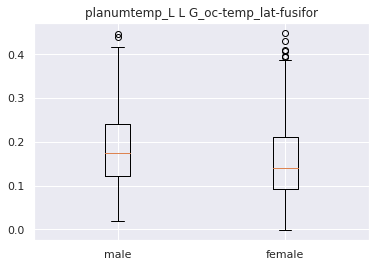

Ttest_indResult(statistic=3.884599647610934, pvalue=0.00011456706619806536)
male mean : 0.18645073
female mean : 0.1582872


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


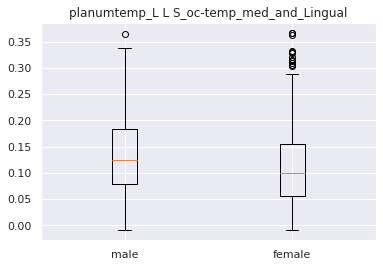

Ttest_indResult(statistic=3.020211908506582, pvalue=0.002639537757200332)
male mean : 0.13396002
female mean : 0.11491338


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


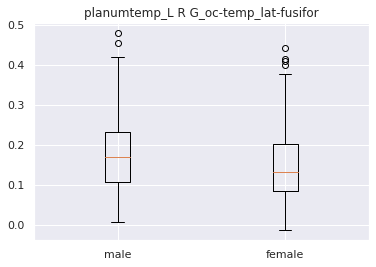

Ttest_indResult(statistic=3.844351881138195, pvalue=0.000134530254843104)
male mean : 0.17783996
female mean : 0.14997594


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


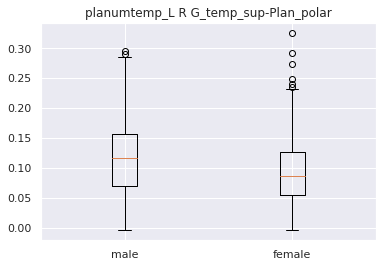

Ttest_indResult(statistic=4.709075761335283, pvalue=3.131282089799687e-06)
male mean : 0.120655425
female mean : 0.09793018


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


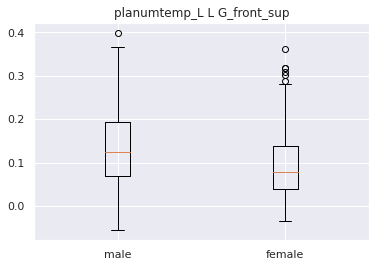

Ttest_indResult(statistic=6.277384960162231, pvalue=6.841155938453079e-10)
male mean : 0.13300735
female mean : 0.09150557


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


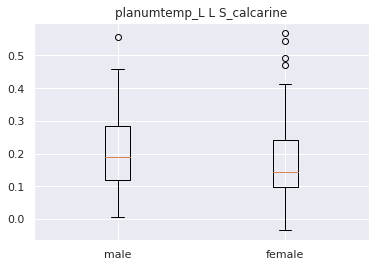

Ttest_indResult(statistic=3.6505599712750856, pvalue=0.0002858230530319466)
male mean : 0.20659167
female mean : 0.17391653


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


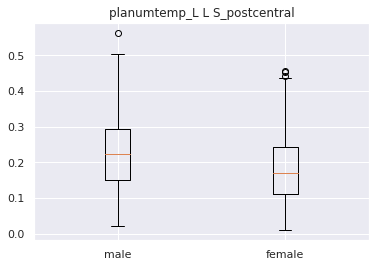

Ttest_indResult(statistic=5.2088191369728305, pvalue=2.6621392371627445e-07)
male mean : 0.22551109
female mean : 0.18211527


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


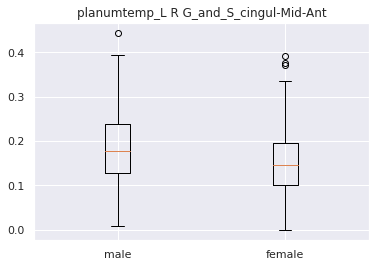

Ttest_indResult(statistic=4.94145850208659, pvalue=1.0217181392073479e-06)
male mean : 0.18532187
female mean : 0.15326016


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


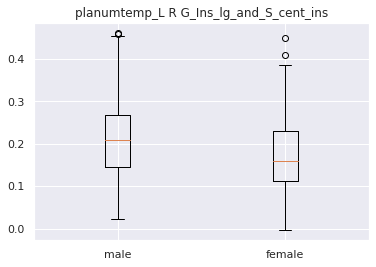

Ttest_indResult(statistic=4.78270058126534, pvalue=2.206867824814024e-06)
male mean : 0.21097915
female mean : 0.17569473


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


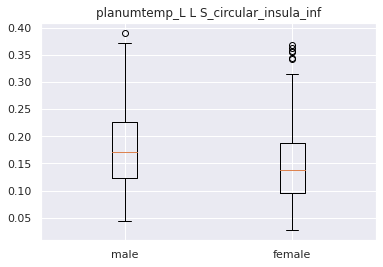

Ttest_indResult(statistic=4.687780341716563, pvalue=3.4617640004702806e-06)
male mean : 0.17687188
female mean : 0.14962009
                                       Region       Men     Women   P value
0      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287  0.000115
1  planumtemp_L - L S_oc-temp_med_and_Lingual   0.13396  0.114913   0.00264
2      planumtemp_L - R G_oc-temp_lat-fusifor   0.17784  0.149976  0.000135
3      planumtemp_L - R G_temp_sup-Plan_polar  0.120655   0.09793  0.000003
4                planumtemp_L - L G_front_sup  0.133007  0.091506       0.0
5                planumtemp_L - L S_calcarine  0.206592  0.173917  0.000286
6              planumtemp_L - L S_postcentral  0.225511  0.182115       0.0
7     planumtemp_L - R G_and_S_cingul-Mid-Ant  0.185322   0.15326  0.000001
8    planumtemp_L - R G_Ins_lg_and_S_cent_ins  0.210979  0.175695  0.000002
9      planumtemp_L - L S_circular_insula_inf  0.176872   0.14962  0.000003


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [60]:
rois = ["planumtemp_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for planumtemp_R

     coefficient          seed                       labels
72      0.193336  planumtemp_R             L S_temporal_sup
47      0.167304  planumtemp_R      L S_circular_insula_inf
60      0.162417  planumtemp_R  L S_oc-temp_med_and_Lingual
43      0.162346  planumtemp_R                L S_calcarine
108     0.159904  planumtemp_R      R G_temp_sup-Plan_polar
121     0.157226  planumtemp_R      R S_circular_insula_inf
20      0.150856  planumtemp_R      L G_oc-temp_lat-fusifor
78      0.117747  planumtemp_R   R G_and_S_transv_frontopol
15      0.114125  planumtemp_R                L G_front_sup
80      0.113967  planumtemp_R     R G_and_S_cingul-Mid-Ant
The mean accuracy : 0.7848601769911504
The standard deviation of the accuracy : 0.039920238590652524
The lower boundry of the confidance interval of the accuracy : 0.7066165093534714
The upper boundry of the confidance interval of the accuracy : 0.8631038446288294


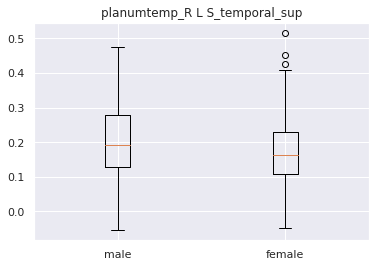

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


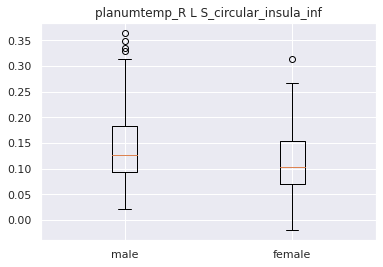

Ttest_indResult(statistic=5.007456260267843, pvalue=7.371794588395764e-07)
male mean : 0.14035343
female mean : 0.11432696


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


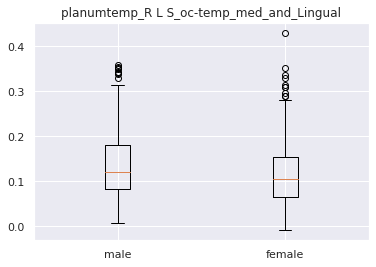

Ttest_indResult(statistic=3.0624233052403027, pvalue=0.00229945814708059)
male mean : 0.13526098
female mean : 0.116651125


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


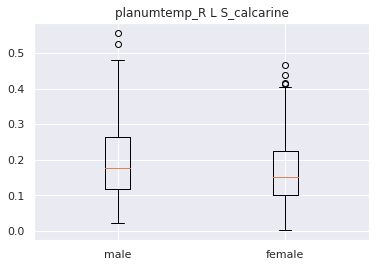

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


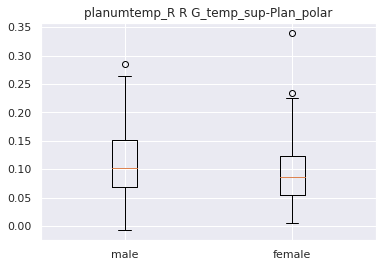

Ttest_indResult(statistic=3.672343154381283, pvalue=0.0002630403504360859)
male mean : 0.111256644
female mean : 0.09470312


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


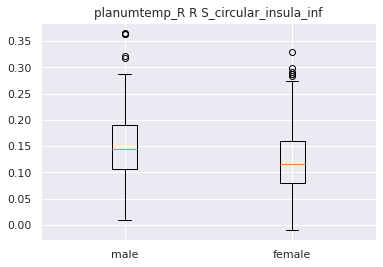

Ttest_indResult(statistic=5.1698335247619145, pvalue=3.2510555654335486e-07)
male mean : 0.15255034
female mean : 0.12557979


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


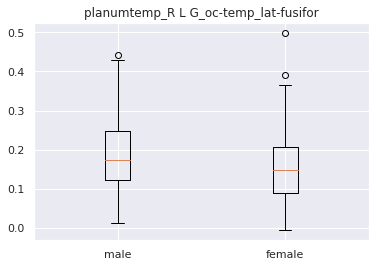

Ttest_indResult(statistic=4.196349599946236, pvalue=3.147371906718927e-05)
male mean : 0.18705179
female mean : 0.15669796


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


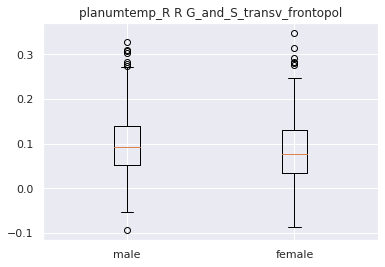

Ttest_indResult(statistic=2.4450835297243194, pvalue=0.014784556396720787)
male mean : 0.09999801
female mean : 0.084834725


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


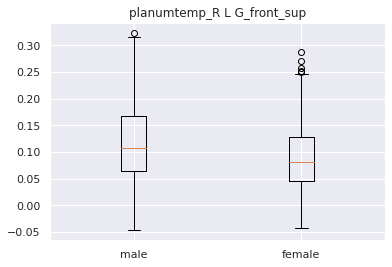

Ttest_indResult(statistic=4.713042385999811, pvalue=3.07317312687487e-06)
male mean : 0.11826675
female mean : 0.09100003


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


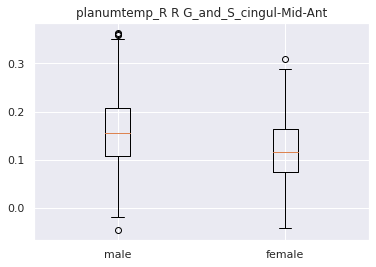

Ttest_indResult(statistic=6.041387569168192, pvalue=2.765055674671749e-09)
male mean : 0.15823741
female mean : 0.12321305
                                       Region       Men     Women   P value
0             planumtemp_R - L S_temporal_sup  0.203941  0.174168  0.000332
1      planumtemp_R - L S_circular_insula_inf  0.140353  0.114327  0.000001
2  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651  0.002299
3                planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
4      planumtemp_R - R G_temp_sup-Plan_polar  0.111257  0.094703  0.000263
5      planumtemp_R - R S_circular_insula_inf   0.15255   0.12558       0.0
6      planumtemp_R - L G_oc-temp_lat-fusifor  0.187052  0.156698  0.000031
7   planumtemp_R - R G_and_S_transv_frontopol  0.099998  0.084835  0.014785
8                planumtemp_R - L G_front_sup  0.118267     0.091  0.000003
9     planumtemp_R - R G_and_S_cingul-Mid-Ant  0.158237  0.123213       0.0


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [63]:
rois = ["planumtemp_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all left seed

     coefficient          seed                       labels
349     0.101883        aMTG_L                L S_front_sup
300     0.091366        aMTG_L   L G_and_S_transv_frontopol
394     0.089612        aMTG_L       R G_pariet_inf-Angular
530     0.088158        pITG_L        R G_front_inf-Orbital
470     0.083322        pITG_L             L G_parietal_sup
453     0.079385        pITG_L      L G_cingul-Post-ventral
208     0.077356  planumtemp_L  L S_oc-temp_med_and_Lingual
569     0.074492        pITG_L                R S_front_inf
351     0.073619        aMTG_L  L S_intrapariet_and_P_trans
168     0.070581  planumtemp_L      L G_oc-temp_lat-fusifor
The mean accuracy : 0.9104362831858407
The standard deviation of the accuracy : 0.028102231489263784
The lower boundry of the confidance interval of the accuracy : 0.8553559094668837
The upper boundry of the confidance interval of the accuracy : 0.9655166569047977


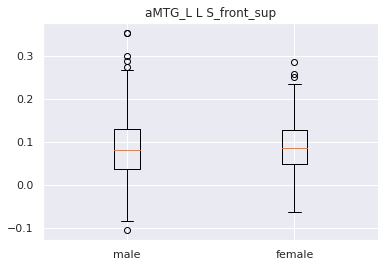

Ttest_indResult(statistic=-0.16306014602567942, pvalue=0.8705290755176053)
male mean : 0.08941226
female mean : 0.09030944


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


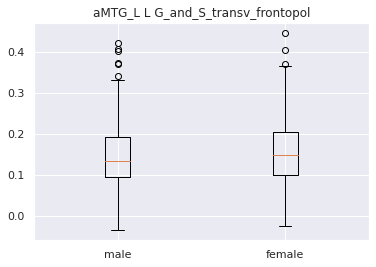

Ttest_indResult(statistic=-0.4347863501222379, pvalue=0.6638826498992696)
male mean : 0.15048955
female mean : 0.15334298


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


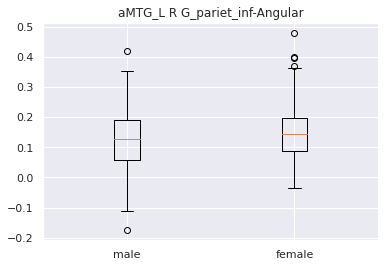

/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


Ttest_indResult(statistic=-2.9146205621255152, pvalue=0.0037015700856202847)
male mean : 0.12457278
female mean : 0.1470128


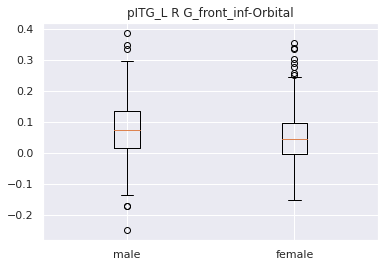

Ttest_indResult(statistic=2.7209463141557952, pvalue=0.006709080081535358)
male mean : 0.07330693
female mean : 0.052528843


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


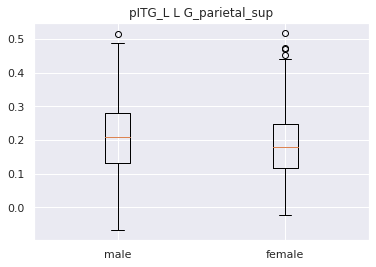

Ttest_indResult(statistic=2.776333935754648, pvalue=0.005678904619509242)
male mean : 0.21009725
female mean : 0.18630977


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


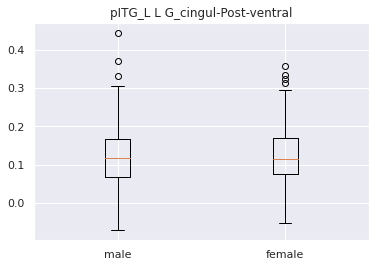

Ttest_indResult(statistic=0.0032246372189609824, pvalue=0.997428248397062)
male mean : 0.121866316
female mean : 0.121846415


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


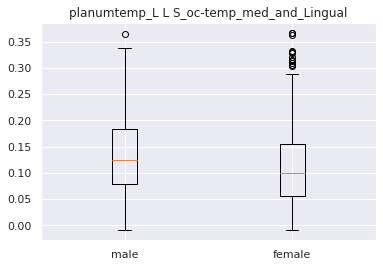

Ttest_indResult(statistic=3.020211908506582, pvalue=0.002639537757200332)
male mean : 0.13396002
female mean : 0.11491338


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


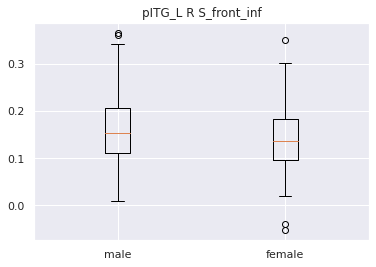

Ttest_indResult(statistic=3.4759879317703635, pvalue=0.0005478613658807853)
male mean : 0.16004132
female mean : 0.14065996


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


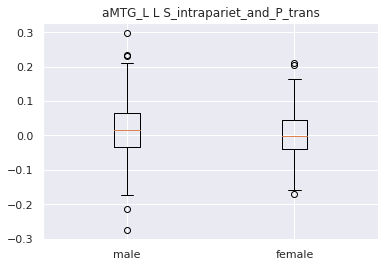

Ttest_indResult(statistic=1.5534617198947105, pvalue=0.1208698513554686)
male mean : 0.014690557
female mean : 0.005323266


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


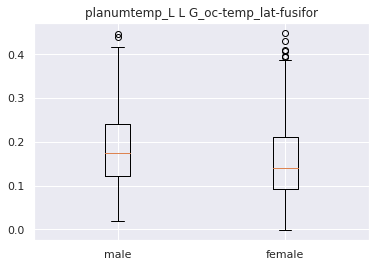

Ttest_indResult(statistic=3.884599647610934, pvalue=0.00011456706619806536)
male mean : 0.18645073
female mean : 0.1582872
                                       Region       Men     Women   P value
0                      aMTG_L - L S_front_sup  0.089412  0.090309  0.870529
1         aMTG_L - L G_and_S_transv_frontopol   0.15049  0.153343  0.663883
2             aMTG_L - R G_pariet_inf-Angular  0.124573  0.147013  0.003702
3              pITG_L - R G_front_inf-Orbital  0.073307  0.052529  0.006709
4                   pITG_L - L G_parietal_sup  0.210097   0.18631  0.005679
5            pITG_L - L G_cingul-Post-ventral  0.121866  0.121846  0.997428
6  planumtemp_L - L S_oc-temp_med_and_Lingual   0.13396  0.114913   0.00264
7                      pITG_L - R S_front_inf  0.160041   0.14066  0.000548
8        aMTG_L - L S_intrapariet_and_P_trans  0.014691  0.005323   0.12087
9      planumtemp_L - L G_oc-temp_lat-fusifor  0.186451  0.158287  0.000115


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [65]:
rois = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

## Best region for all right seed

     coefficient          seed                       labels
464     0.102106        pITG_R      L G_oc-temp_lat-fusifor
349     0.100792        aMTG_R                L S_front_sup
191     0.090907  planumtemp_R                L S_calcarine
569     0.087700        pITG_R                R S_front_inf
379     0.083245        aMTG_R      R G_cingul-Post-ventral
144     0.081880       opIFG_R              R S_subparietal
300     0.079514        aMTG_R   L G_and_S_transv_frontopol
431     0.079232        aMTG_R          R S_orbital_lateral
208     0.078835  planumtemp_R  L S_oc-temp_med_and_Lingual
220     0.077796  planumtemp_R             L S_temporal_sup
The mean accuracy : 0.9012778761061947
The standard deviation of the accuracy : 0.029758982557172946
The lower boundry of the confidance interval of the accuracy : 0.8429502702941357
The upper boundry of the confidance interval of the accuracy : 0.9596054819182537


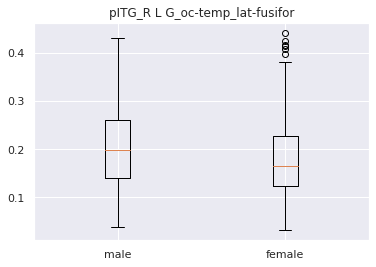

Ttest_indResult(statistic=3.2774844460194017, pvalue=0.0011113279198056616)
male mean : 0.20170005
female mean : 0.17975447


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


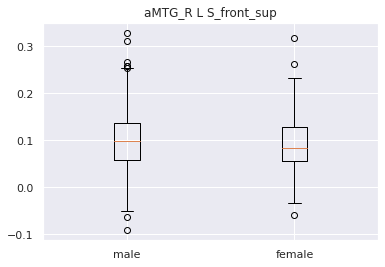

Ttest_indResult(statistic=1.3124199191098709, pvalue=0.1899085676690528)
male mean : 0.09976947
female mean : 0.0929379


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


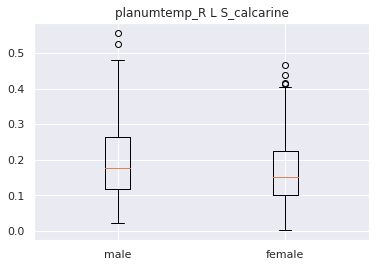

Ttest_indResult(statistic=3.1724387321603484, pvalue=0.0015932969773334883)
male mean : 0.19657883
female mean : 0.1700965


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


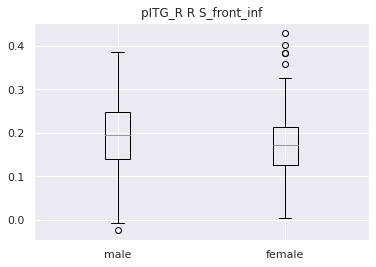

Ttest_indResult(statistic=3.5885077171556365, pvalue=0.0003613019486017472)
male mean : 0.19545709
female mean : 0.17458448


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


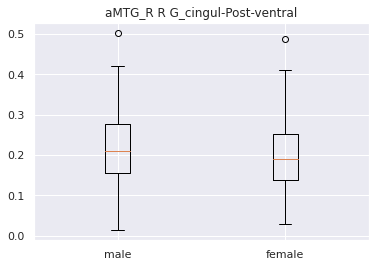

Ttest_indResult(statistic=2.9173803459664653, pvalue=0.0036694581263624366)
male mean : 0.2160543
female mean : 0.1958651


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


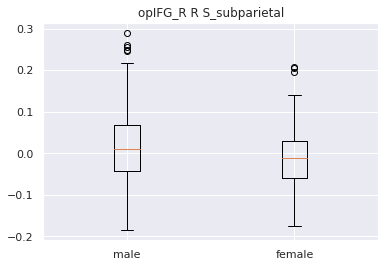

Ttest_indResult(statistic=4.565861009572576, pvalue=6.1028631539739194e-06)
male mean : 0.016530583
female mean : -0.012515795


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


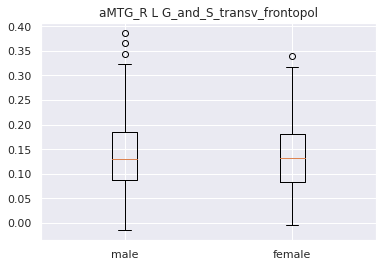

Ttest_indResult(statistic=0.6162901616659396, pvalue=0.5379499355179367)
male mean : 0.14077756
female mean : 0.13714556


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


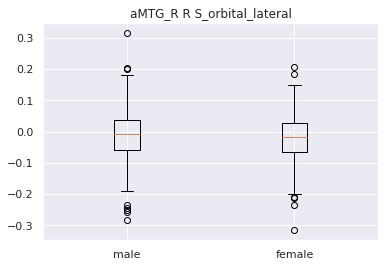

Ttest_indResult(statistic=0.8920637158306071, pvalue=0.37273653091063785)
male mean : -0.010003094
female mean : -0.016048837


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


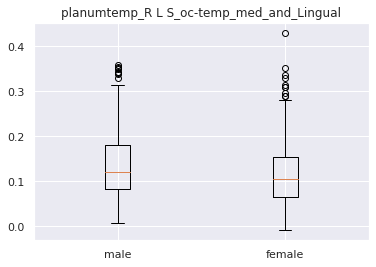

Ttest_indResult(statistic=3.0624233052403027, pvalue=0.00229945814708059)
male mean : 0.13526098
female mean : 0.116651125


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


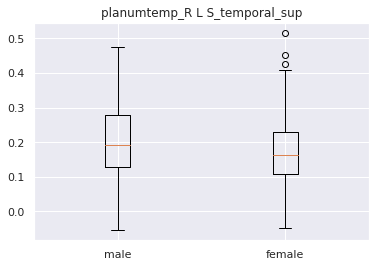

Ttest_indResult(statistic=3.61097793210399, pvalue=0.000332036608740878)
male mean : 0.20394091
female mean : 0.1741676
                                       Region       Men     Women   P value
0            pITG_R - L G_oc-temp_lat-fusifor    0.2017  0.179754  0.001111
1                      aMTG_R - L S_front_sup  0.099769  0.092938  0.189909
2                planumtemp_R - L S_calcarine  0.196579  0.170097  0.001593
3                      pITG_R - R S_front_inf  0.195457  0.174584  0.000361
4            aMTG_R - R G_cingul-Post-ventral  0.216054  0.195865  0.003669
5                   opIFG_R - R S_subparietal  0.016531 -0.012516  0.000006
6         aMTG_R - L G_and_S_transv_frontopol  0.140778  0.137146   0.53795
7                aMTG_R - R S_orbital_lateral -0.010003 -0.016049  0.372737
8  planumtemp_R - L S_oc-temp_med_and_Lingual  0.135261  0.116651  0.002299
9             planumtemp_R - L S_temporal_sup  0.203941  0.174168  0.000332


/tmp/ipykernel_2378536/4089267212.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table_best = table_best.append({'Region' : best_roi[i][0] + " - " + best_roi[i][1],


In [67]:
rois = ["opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"] # modified to rois of interest
ROIs = regionsOfInterest(data_results["acc_test"], pvalue, moyenne, rois, label, run_1)
bestRegion(ROIs)

# Connectome

In [8]:
atlas_dest = datasets.fetch_atlas_destrieux_2009(legacy_format=False)
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_dest["maps"])
label = atlas_dest["labels"].drop([0,42,117])
label = label.reset_index()
connectome_measure = ConnectivityMeasure(kind="correlation")



## aMTG_R

In [24]:
label_male = []
label_female = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["subject_label"][i])

    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["subject_label"][i])
        

        
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    
    
# 959      0.016141        aMTG_R          L S_temporal_inf
# 453      0.015930        pITG_L   L G_cingul-Post-ventral
# 866      0.014635  planumtemp_R          R S_front_middle
# 598      0.014404       opIFG_R  L G_and_S_cingul-Mid-Ant
# 1014     0.014371        aMTG_R          R S_front_middle
# 900      0.012792        aMTG_R     L G_front_inf-Orbital
# 1012     0.012738        aMTG_R    R S_collat_transv_post
# 1002     0.012191        aMTG_R            R Lat_Fis-post
# 923      0.011730        aMTG_R   L G_temp_sup-Plan_tempo
# 983      0.011674        aMTG_R   R G_oc-temp_med-Lingual

print(label[label["name"] == "L S_temporal_inf"].index[0])
print(label[label["name"] == "R S_front_middle"].index[0])
print(label[label["name"] == "L G_front_inf-Orbital"].index[0])
print(label[label["name"] == "R S_collat_transv_post"].index[0])
print(label[label["name"] == "R Lat_Fis-post"].index[0])
print(label[label["name"] == "L G_temp_sup-Plan_tempo"].index[0])
print(label[label["name"] == "R G_oc-temp_med-Lingual"].index[0])

connectome_coord = np.array([coordinates[71], coordinates[126], coordinates[12], coordinates[124], coordinates[114], 
                             coordinates[35], coordinates[95]])

connectome_matrix_male = np.array([mean_correlation_male[71], mean_correlation_male[126], mean_correlation_male[12], mean_correlation_male[124],
                             mean_correlation_male[114], mean_correlation_male[35], mean_correlation_male[95]])

connectome_matrix_female = np.array([mean_correlation_female[71], mean_correlation_female[126], mean_correlation_female[12], mean_correlation_female[124],
                             mean_correlation_female[114], mean_correlation_female[35], mean_correlation_female[95]])

# plotting.plot_connectome(connectome_matrix,
#                         connectome_coord,
#                         display_mode="ortho",
#                         edge_threshold="80%")
#plot_male = plotting.plot_markers(connectome_matrix_male, connectome_coord, node_cmap="seismic", display_mode="lyrz")
#plot_male.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size = 100)
#plot_female = plotting.plot_markers(connectome_matrix_female, connectome_coord, node_cmap="seismic", display_mode="lyrz")
#plot_female.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size=100)

71
126
12
124
114
35
95


In [169]:
mean_correlation_female[71]

0.049179014

In [170]:
mean_correlation_male[71]

0.072253615

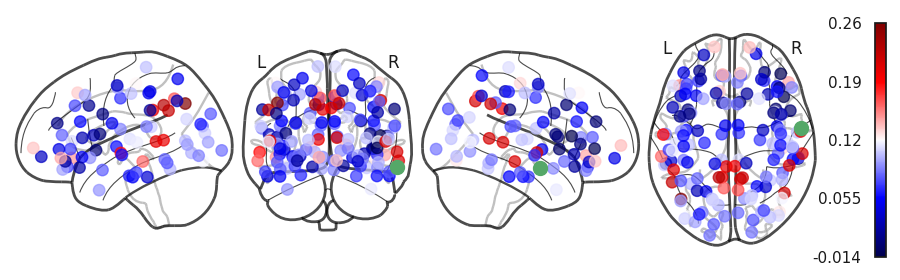

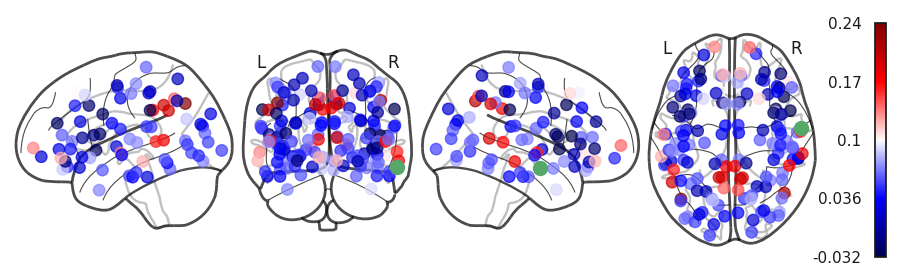

In [30]:
label_male = []
label_female = []

for i in range(0,len(Final_df["Gender"])):
    if Final_df["Gender"][i] == 0:
        label_male.append(Final_df["subject_label"][i])

    elif Final_df["Gender"][i] == 1:
        label_female.append(Final_df["subject_label"][i])
        

        
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    
# Each node will be colored according to corresponding node value.
# Nodes are color coded according to provided nodal measure. Nodal measure usually represents some notion of node importance.

plot_male_aMTG = plotting.plot_markers(mean_correlation_male, coordinates, node_cmap="seismic", display_mode="lyrz", #node_threshold=0.15)   
                                      )
plot_male_aMTG.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size = 100)

plot_female_aMTG = plotting.plot_markers(mean_correlation_female, coordinates, node_cmap="seismic", display_mode="lyrz", #node_threshold=0.15)     
                                        )
plot_female_aMTG.add_markers(marker_coords=[(60, -6, -18)], marker_color="g", marker_size=100)

## Connectome aMTG_R

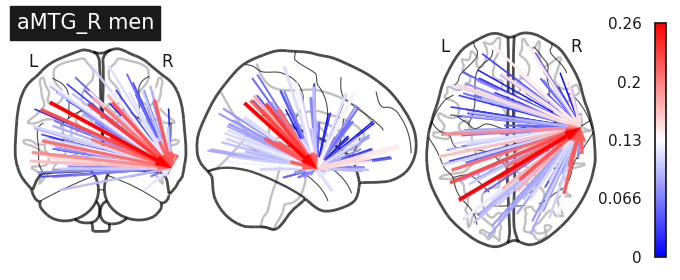

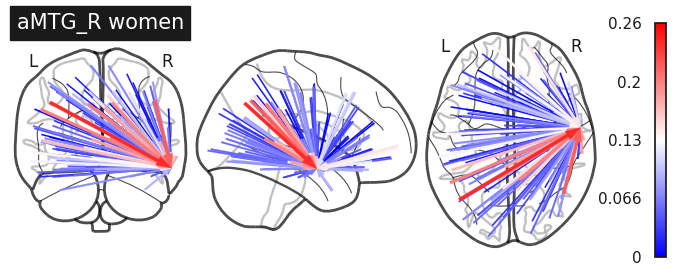

In [115]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_aMTG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

edge_max = 0.20
sns.set_theme(context="notebook")

fig_men = plotting.plot_connectome(correlation_matrix_aMTG_male, 
                        np.insert(coordinates, 0, [60, -6, -18], axis=0),
                        edge_vmin=0, 
                        edge_vmax=np.max(correlation_matrix_aMTG_male), 
                        display_mode="ortho", 
                        node_size = 0, 
                        colorbar = True, 
                        title = "aMTG_R men", 
                        #edge_cmap="gnuplot",
                        edge_kwargs={"linewidth":0.15}
                              )



correlation_matrix_aMTG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_aMTG_female, 
                        np.insert(coordinates, 0, [60, -6, -18], axis=0),
                        edge_vmin=0, 
                        edge_vmax=np.max(correlation_matrix_aMTG_male),
                        display_mode="ortho",
                        node_size = 0, 
                        colorbar = True, 
                        title = "aMTG_R women",
                        #edge_cmap="gnuplot",
                        edge_kwargs={"linewidth":0.15})


## Connectome aMTG_L

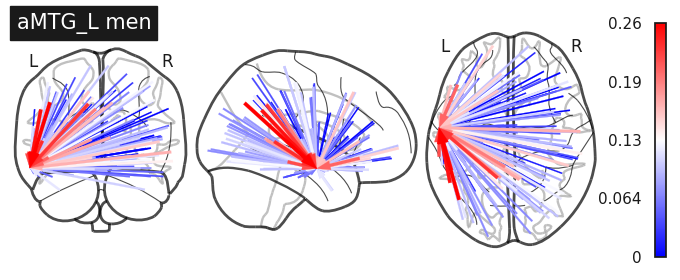

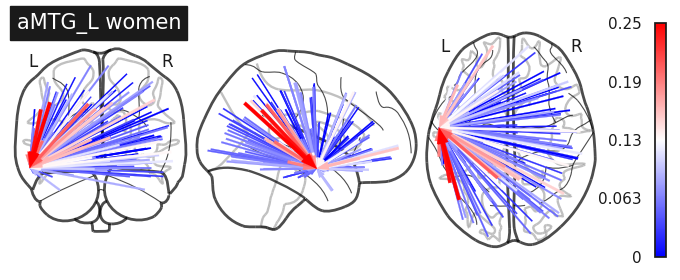

In [114]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "aMTG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "aMTG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_aMTG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_aMTG_male, 
                        np.insert(coordinates, 0, [-60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_L men",
                        edge_kwargs={"linewidth":0.15})


correlation_matrix_aMTG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_aMTG_female, 
                        np.insert(coordinates, 0, [-60, -6, -18], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_aMTG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "aMTG_L women",
                        edge_kwargs={"linewidth":0.15})

## opIFG_L 

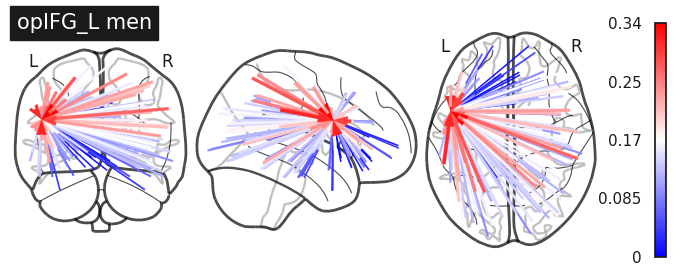

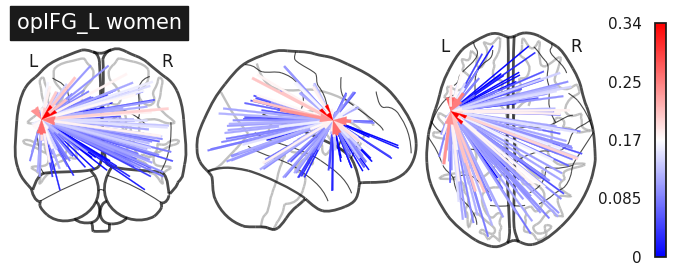

In [124]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "opIFG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "opIFG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_opIFG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

fig_men = plotting.plot_connectome(correlation_matrix_opIFG_male, 
                        np.insert(coordinates, 0, [-50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_L men",
                        edge_kwargs={"linewidth":0.15})

fig_men.savefig("opIFG_L_Men.png", dpi= 300)

correlation_matrix_opIFG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

fig_women = plotting.plot_connectome(correlation_matrix_opIFG_female, 
                        np.insert(coordinates, 0, [-50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_L women",
                        edge_kwargs={"linewidth":0.15})
fig_women.savefig("opIFG_L_Women.png",dpi=300)

# opIFG_R

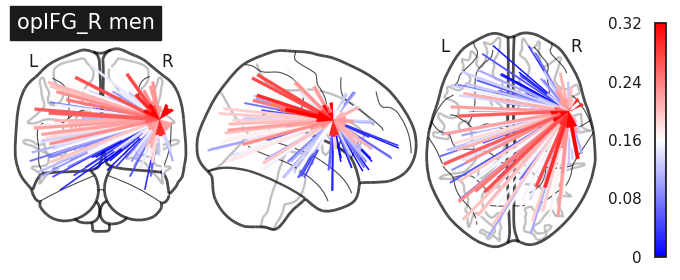

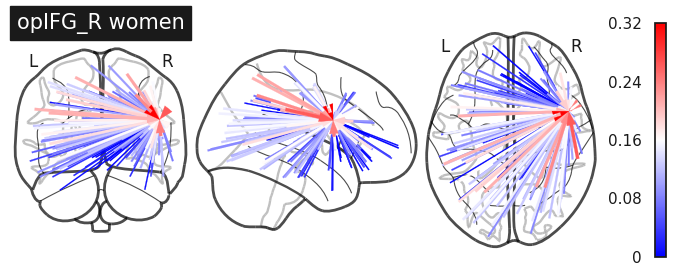

In [112]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "opIFG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "opIFG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_opIFG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_opIFG_male, 
                        np.insert(coordinates, 0, [50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_R men",
                        edge_kwargs={"linewidth":0.15})


correlation_matrix_opIFG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_opIFG_female, 
                        np.insert(coordinates, 0, [50, 8, 23], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_opIFG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "opIFG_R women",
                        edge_kwargs={"linewidth":0.15})

# pITG_L

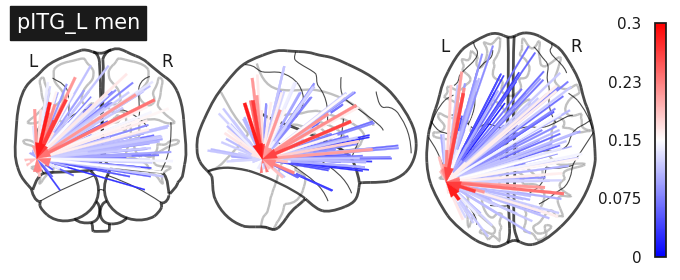

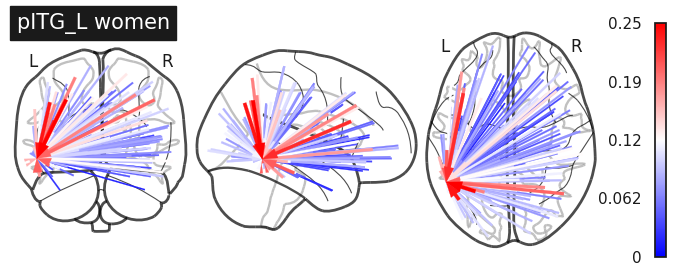

In [116]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "pITG_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "pITG_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_pITG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_pITG_male, 
                        np.insert(coordinates, 0, [-54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_L men",
                        edge_kwargs={"linewidth":0.15})


correlation_matrix_pITG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_pITG_female, 
                        np.insert(coordinates, 0, [-54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_L women",
                        edge_kwargs={"linewidth":0.15})

# pITG_R

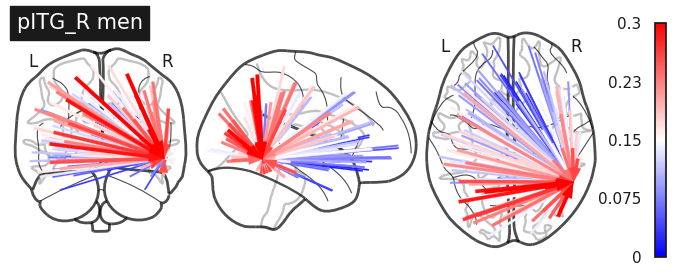

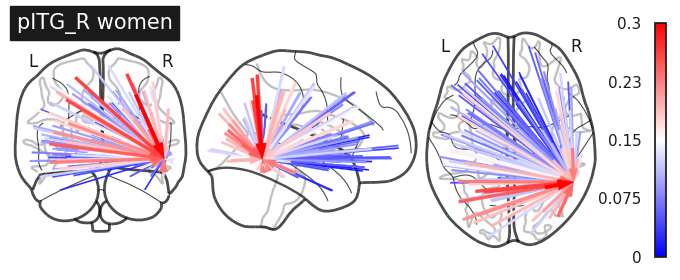

In [111]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "pITG_R")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "pITG_R")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_pITG_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_pITG_male, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_R men",
                        edge_kwargs={"linewidth":0.15})


correlation_matrix_pITG_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_pITG_female, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_pITG_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "pITG_R women",
                        edge_kwargs={"linewidth":0.15})

# planumtemp_L


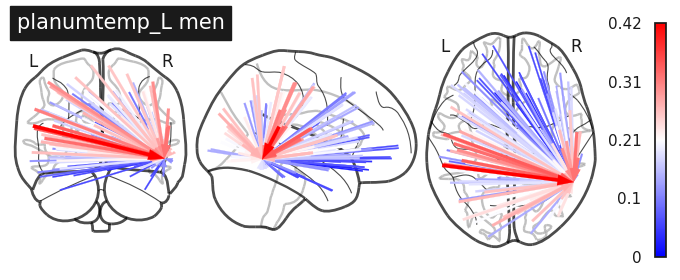

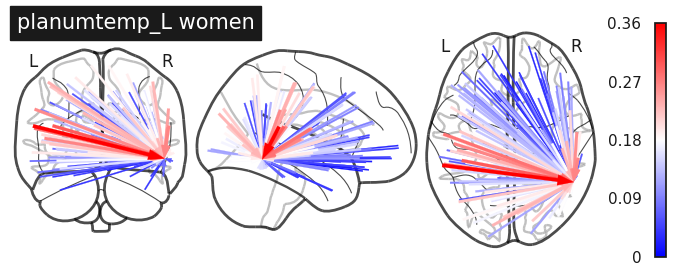

In [110]:
correlation_brain_male = []
correlation_brain_female = []

for i in label_male:
    correlation_brain_male.append(data[(i, "planumtemp_L")])
    
for i in label_female:
    correlation_brain_female.append(data[(i, "planumtemp_L")])
    
mean_correlation_male = np.mean(np.asarray(correlation_brain_male), axis=0)
mean_correlation_female = np.mean(np.asarray(correlation_brain_female), axis=0)
    

zeros = np.zeros((149, 148))
correlation_matrix_planumtemp_male = np.c_[np.insert(mean_correlation_male, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_planumtemp_male, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_male),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_L men",
                        edge_kwargs={"linewidth":0.15})


correlation_matrix_planumtemp_female = np.c_[np.insert(mean_correlation_female, 0, 0), zeros]

plotting.plot_connectome(correlation_matrix_planumtemp_female, 
                        np.insert(coordinates, 0, [54, -52,-10], axis=0),
                        edge_vmin=0,
                        edge_vmax=np.max(correlation_matrix_planumtemp_female),
                        display_mode="ortho", node_size = 0,
                        colorbar = True,
                        title = "planumtemp_L women",
                        edge_kwargs={"linewidth":0.15})

# Correlation between resting state

In [96]:
SEEDS = ["opIFG_L", "planumtemp_L", "aMTG_L", "pITG_L", "opIFG_R", "planumtemp_R", "aMTG_R", "pITG_R"]
img_tpl_REST1LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST1RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1RL_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2LR = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST2LR_seed-{seed_name}__voxelcorrelations.nii.gz"
img_tpl_REST2RL = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results_3D/{seed_name}/sub-{participant_id}/sub-{participant_id}_ses-REST1LR_seed-{seed_name}__voxelcorrelations.nii.gz"

Final_df["subject_label"]
atlas_dest = datasets.fetch_atlas_destrieux_2009()
masker = NiftiLabelsMasker(atlas_dest.maps)

for seed in SEEDS:
    corr_1LR_1RL = []
    corr_1LR_2LR = []
    corr_1LR_2RL = []
    corr_1RL_2LR = []
    corr_1RL_2RL = []
    corr_2LR_2RL = []
    rest1LR = []
    rest1RL = []
    rest2LR = []
    rest2RL = []
    
    rest1LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest1RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST1RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2LR.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2LR.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
    rest2RL.append(joblib.Parallel(n_jobs = 8)(joblib.delayed(img4d2vector)(img_tpl_REST2RL.format(seed_name=seed, participant_id=participant), masker) for participant in Final_df["subject_label"]))
        
    for j in range(0, len(rest1LR[0])):
        corr_1LR_1RL.append(np.corrcoef(rest1LR[0][j], rest1RL[0][j])[0][1])
        corr_1LR_2LR.append(np.corrcoef(rest1LR[0][j], rest2LR[0][j])[0][1])
        corr_1LR_2RL.append(np.corrcoef(rest1LR[0][j], rest2RL[0][j])[0][1])
        corr_1RL_2LR.append(np.corrcoef(rest1RL[0][j], rest2LR[0][j])[0][1])
        corr_1RL_2RL.append(np.corrcoef(rest1RL[0][j], rest2RL[0][j])[0][1])
        corr_2LR_2RL.append(np.corrcoef(rest2LR[0][j], rest2RL[0][j])[0][1])
        
        
    print(seed)
    print("rest1LR and rest1RL")
    print("mean : " + str(np.mean(corr_1LR_1RL)))
    print("min : " + str(min(corr_1LR_1RL)))
    print("max : " + str(max(corr_1LR_1RL)))
    print("\n")
    print("rest1LR and rest2LR")
    print("mean : " + str(np.mean(corr_1LR_2LR)))
    print("min : " + str(min(corr_1LR_2LR)))
    print("max : " + str(max(corr_1LR_2LR)))
    print("\n")
    print("rest1LR and rest2RL")
    print("mean : " + str(np.mean(corr_1LR_2RL)))
    print("min : " + str(min(corr_1LR_2RL)))
    print("max : " + str(max(corr_1LR_2RL)))
    print("\n")
    print("rest1RL and rest2LR")
    print("mean : " + str(np.mean(corr_1RL_2LR)))
    print("min : " + str(min(corr_1RL_2LR)))
    print("max : " + str(max(corr_1RL_2LR)))
    print("\n")
    print("rest1RL and rest2RL")
    print("mean : " + str(np.mean(corr_1RL_2RL)))
    print("min : " + str(min(corr_1RL_2RL)))
    print("max : " + str(max(corr_1RL_2RL)))
    print("\n")
    print("rest2LR and rest2RL")
    print("mean : " + str(np.mean(corr_2LR_2RL)))
    print("min : " + str(min(corr_2LR_2RL)))
    print("max : " + str(max(corr_2LR_2RL)))
    print("\n")
    print("\n")

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:288: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


opIFG_L
rest1LR and rest1RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest1LR and rest2LR
mean : 0.7698490941301699
min : 0.1018440521993477
max : 0.9586093500051478


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7750584728732756
min : 0.05147001936993981
max : 0.9511524080813849


rest1RL and rest2RL
mean : 0.7838370866225765
min : 0.20755749610501092
max : 0.9697692157501481


rest2LR and rest2RL
mean : 0.7698490941301698
min : 0.10184405219934768
max : 0.9586093500051476




planumtemp_L
rest1LR and rest1RL
mean : 0.7885160499127559
min : 0.11528407305428233
max : 0.9650591348987411


rest1LR and rest2LR
mean : 0.7693670776944767
min : 0.12378670509244566
max : 0.970730776939474


rest1LR and rest2RL
mean : 1.0
min : 0.9999999999999998
max : 1.0


rest1RL and rest2LR
mean : 0.7611741204293923
min : 0.05853655064429218
max : 0.9535431025556377


rest1RL and rest2RL
mean : 0.7885160499127559
min :